# **Setup**

In [62]:
from dataclasses import dataclass
from typing import Dict, Any, List, Tuple, Optional
import os
import json
import tempfile
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Optional, Iterable

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix

# Imported only where used to avoid hard dependency on optional libs at import time
import optuna
import mlflow
from optuna.integration.mlflow import MLflowCallback

In [54]:
try:
    import xgboost as xgb
except Exception:
    xgb = None

try:
    import lightgbm as lgb
except Exception:
    lgb = None

# **System Check**

In [2]:
import sys, time, os
print("Kernel OK:", sys.executable)
time.sleep(1)
print("CWD:", os.getcwd())

Kernel OK: c:\Users\betoa\anaconda3\envs\mlops312\python.exe
CWD: c:\Users\betoa\Documents\TEC\MLOPS\Gits\Fase2\MLOps_Equipo_63\notebooks


In [3]:
import sys; print(sys.version); print(sys.executable)

3.12.12 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 20:05:38) [MSC v.1929 64 bit (AMD64)]
c:\Users\betoa\anaconda3\envs\mlops312\python.exe


# **Loading**

In [4]:
@dataclass
class Config:
    data_path: str = "C:\\Users\\betoa\\Documents\\TEC\\MLOPS\\Gits\\Fase2\\MLOps_Equipo_63\\references\\online_news_modified.csv"
# original path: r"C:\Users\betoa\Documents\TEC\MLOPS\Gits\Fase2\MLOps_Equipo_63\references\online_news.csv"
    target_col: str = "shares"
    pos_label_threshold: int = 1400
    test_size: float = 0.2
    random_state: int = 42
    n_trials: int = 50
    cv_folds: int = 5
    study_name: str = "fase2_optuna_study"
    mlflow_experiment: str = "Equipo63_Fase2"
    mlflow_tracking_uri: str = os.environ.get("MLFLOW_TRACKING_URI", "mlruns")

# **Data Exploration**

In [5]:
def load_data(filepath):
    """Load dataset from a CSV file."""
    df = pd.read_csv(filepath)
    return df

def explore_data(df):
    """Explore the dataset and print basic information."""
    pd.set_option('display.max_rows', 200)
    pd.set_option('display.max_columns', 100)
    pd.set_option('display.width', 2000)
    print("Dataset Shape:", df.shape)
    print("First 5 rows of the dataset:")
    print(df.head())
    print("\nDataset Info:")
    print(df.info())
    print("\nStatistical Summary:")
    print(df.describe().T)
    print("\nMissing Values:")
    #Porcentaje de valores faltantes por columna.
    data_observaciones = df.shape[0]
    missing_values_count = df.isna().sum()
    print(round(missing_values_count*100/data_observaciones,2))
    print("Total de registros:",df.shape[0])
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')

In [8]:
explore_data(load_data(Config().data_path))
df = load_data(Config().data_path)

Dataset Shape: (40436, 62)
First 5 rows of the dataset:
                                                 url timedelta n_tokens_title n_tokens_content  n_unique_tokens n_non_stop_words n_non_stop_unique_tokens num_hrefs num_self_hrefs num_imgs num_videos average_token_length num_keywords data_channel_is_lifestyle data_channel_is_entertainment data_channel_is_bus data_channel_is_socmed data_channel_is_tech data_channel_is_world kw_min_min kw_max_min kw_avg_min kw_min_max kw_max_max kw_avg_max kw_min_avg kw_max_avg kw_avg_avg self_reference_min_shares self_reference_max_shares self_reference_avg_sharess weekday_is_monday weekday_is_tuesday weekday_is_wednesday weekday_is_thursday weekday_is_friday weekday_is_saturday weekday_is_sunday is_weekend           LDA_00           LDA_01           LDA_02           LDA_03           LDA_04 global_subjectivity global_sentiment_polarity global_rate_positive_words global_rate_negative_words rate_positive_words rate_negative_words avg_positive_polarity

# **Preparing Data for Visualization**

In [14]:
def prepare_numeric_df(df: pd.DataFrame,
                       exclude_cols: list[str] = ['url'],
                       label_col: str = 'shares',
                       drop_cols: list[str] = ['url', 'timedelta'],
                       impute_strategy: str = 'median'):
    "Prepares a DataFrame by converting columns to numeric, handling missing values, and dropping unnecessary columns."
    df_numeric = pd.DataFrame()
    non_numeric_cols = []

    # Convertir columnas a numéricas excepto las excluidas
    for col in df.columns:
        if col in exclude_cols:
            continue
        try:
            df_numeric[col] = pd.to_numeric(df[col], errors='coerce')
        except (ValueError, TypeError):
            non_numeric_cols.append(col)

    print("Columnas que no se pudieron convertir a numéricas:")
    print(non_numeric_cols)

    # Eliminar registros con NaN en el label
    if label_col in df_numeric.columns:
        df_numeric.dropna(subset=[label_col], inplace=True)

    # Eliminar columnas innecesarias
    for col in drop_cols:
        if col in df_numeric.columns:
            df_numeric.drop(columns=[col], inplace=True)

    # Imputar valores faltantes con la estrategia elegida
    imputer = SimpleImputer(strategy=impute_strategy)
    df_numeric = pd.DataFrame(imputer.fit_transform(df_numeric), columns=df_numeric.columns)

    # Calcular porcentaje de valores faltantes
    missing_values_percentage = (df_numeric.isnull().sum() / len(df_numeric)) * 100
    print("\nPorcentaje de valores faltantes por columna:")
    print(missing_values_percentage)

    return df_numeric

In [15]:
prepare_numeric_df(df)
df_numeric = prepare_numeric_df(df)

Columnas que no se pudieron convertir a numéricas:
[]

Porcentaje de valores faltantes por columna:
n_tokens_title                   0.0
n_tokens_content                 0.0
n_unique_tokens                  0.0
n_non_stop_words                 0.0
n_non_stop_unique_tokens         0.0
num_hrefs                        0.0
num_self_hrefs                   0.0
num_imgs                         0.0
num_videos                       0.0
average_token_length             0.0
num_keywords                     0.0
data_channel_is_lifestyle        0.0
data_channel_is_entertainment    0.0
data_channel_is_bus              0.0
data_channel_is_socmed           0.0
data_channel_is_tech             0.0
data_channel_is_world            0.0
kw_min_min                       0.0
kw_max_min                       0.0
kw_avg_min                       0.0
kw_min_max                       0.0
kw_max_max                       0.0
kw_avg_max                       0.0
kw_min_avg                       0.0
kw_max_avg  

# **Visualizing Data (EDA)**

In [24]:
class EDAPlotter:
    def __init__(self, df: pd.DataFrame, figsize_hist=(10,6), figsize_box=(6,4), corr_method="pearson"):
        self.df = df
        self.figsize_hist = figsize_hist
        self.figsize_box = figsize_box
        self.corr_method = corr_method

    def plot_hist(self, col: str = "shares", bins: int = 100):
        if col not in self.df.columns:
            raise ValueError(f"'{col}' no está en el DataFrame.")
        plt.figure(figsize=self.figsize_hist)
        plt.hist(self.df[col].dropna(), bins=bins)
        plt.title(f"Distribution of {col} (Histogram)")
        plt.xlabel(f"{col} (binned)")
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()

    def plot_boxplots(self, cols: Optional[Iterable[str]] = None):
        cols = list(cols) if cols is not None else list(self.df.columns)
        for c in cols:
            if c not in self.df.columns:
                print(f"[warn] '{c}' no está en el DataFrame, se omite.")
                continue
            plt.figure(figsize=self.figsize_box)
            sns.boxplot(x=self.df[c].dropna())
            plt.title(f"Distribution of {c}")
            plt.xlabel(c)
            plt.ylabel("Value")
            plt.tight_layout()
            plt.show()
            plt.close()

    def correlation(self, plot: bool = False, decimals: int = 2):
        corr = self.df.corr(numeric_only=True, method=self.corr_method)
        if plot:
            plt.rcParams.update({'font.size': 6})
            plt.figure(figsize=(25, 25))
            corr_to_plot = corr.round(decimals) if decimals is not None else corr
            sns.heatmap(corr_to_plot, center=0,annot=True, fmt=".2f")
            plt.title(f"Correlation Matrix ({self.corr_method})")
            plt.tight_layout()
            plt.show()
        return corr_to_plot



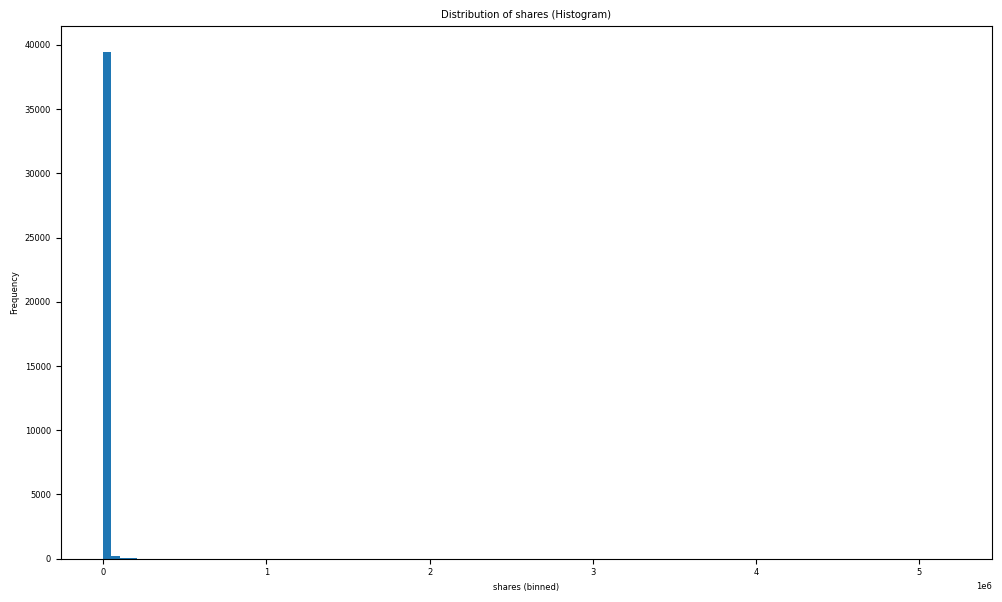

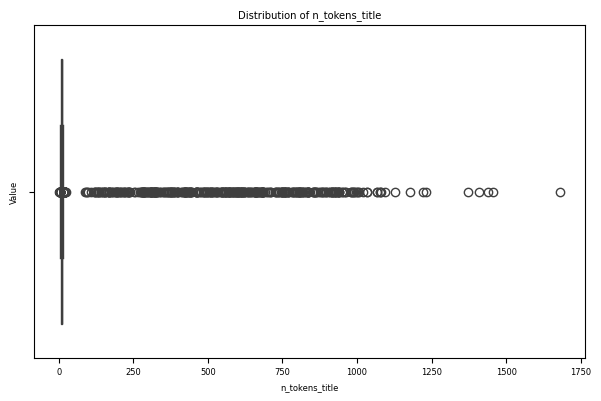

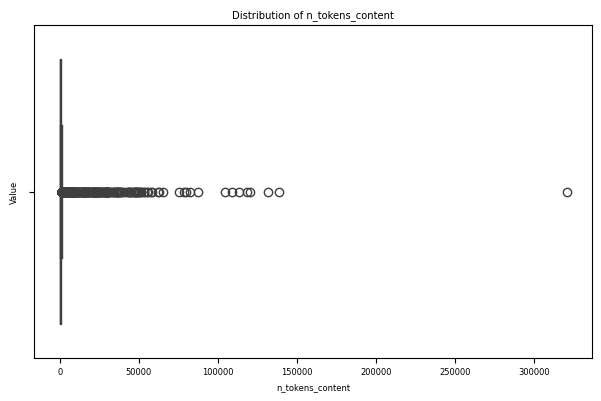

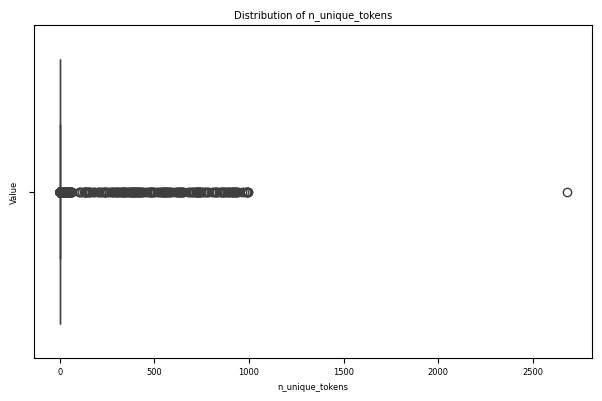

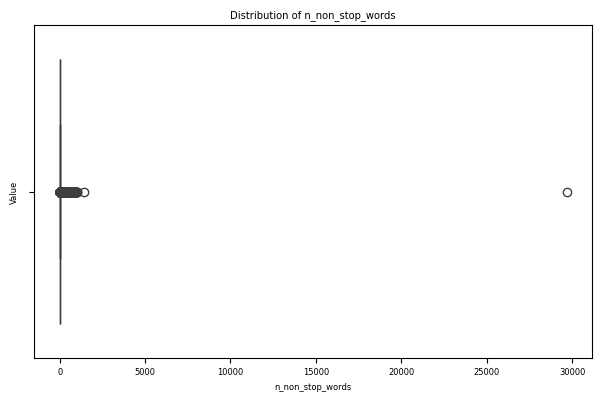

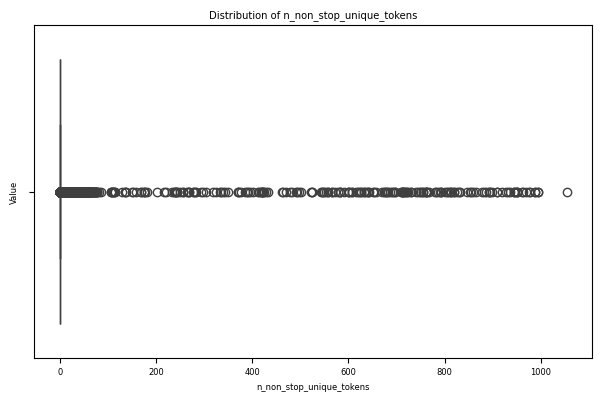

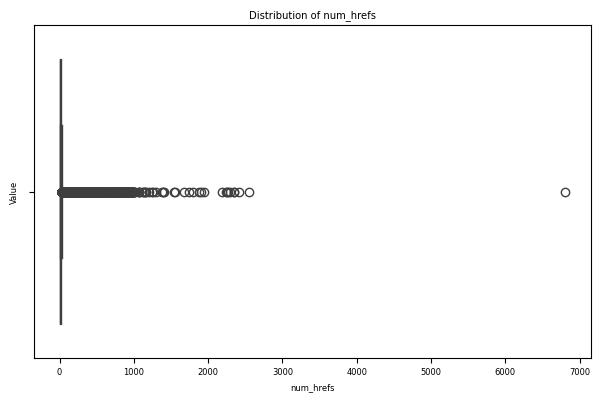

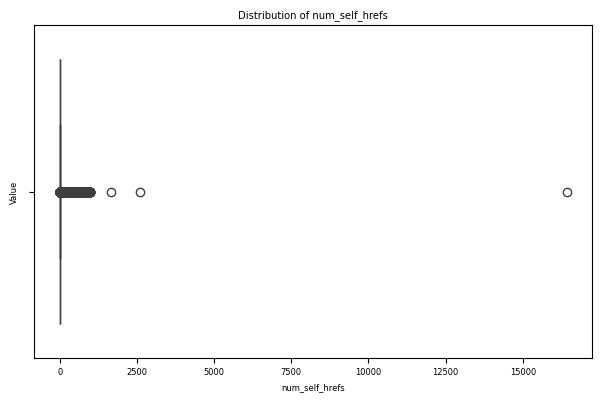

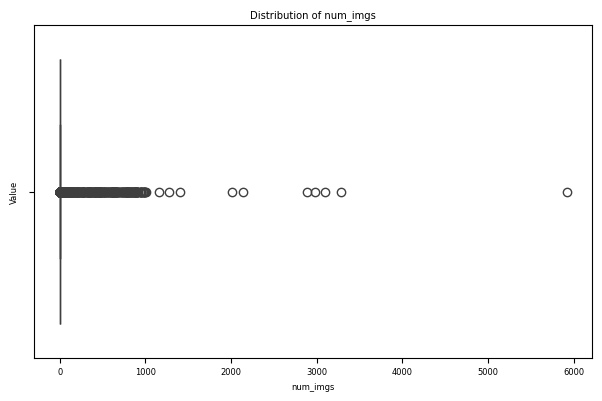

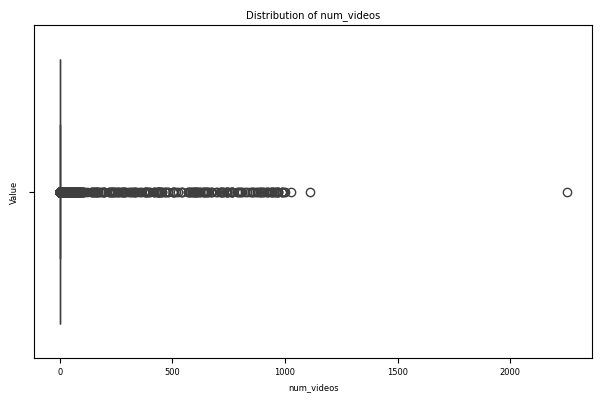

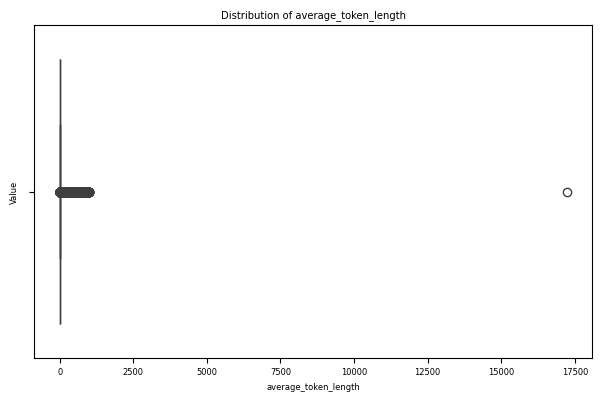

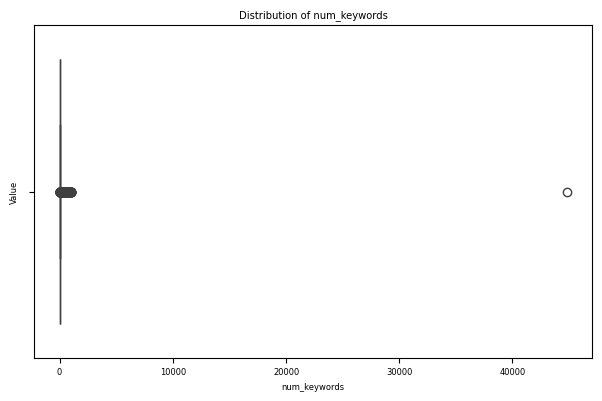

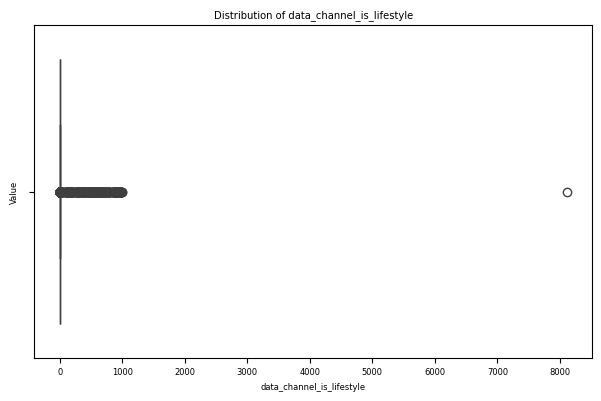

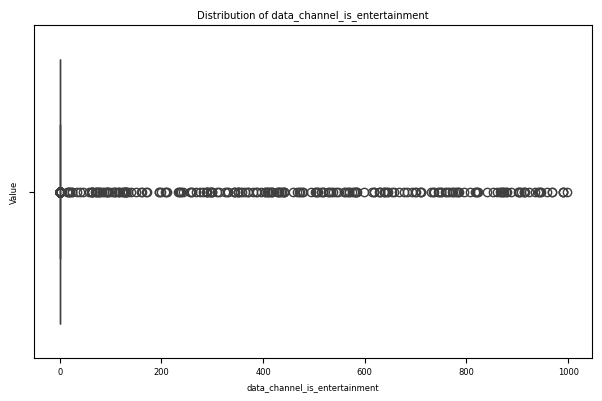

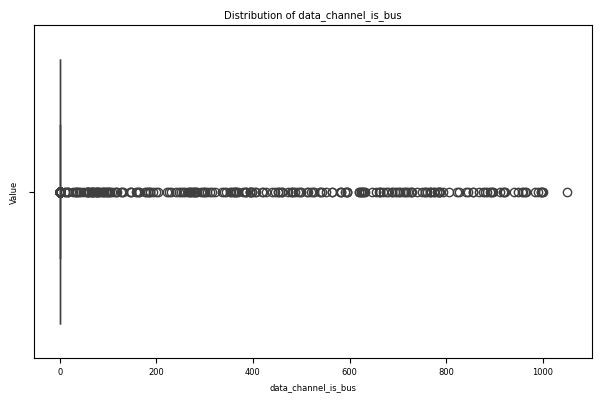

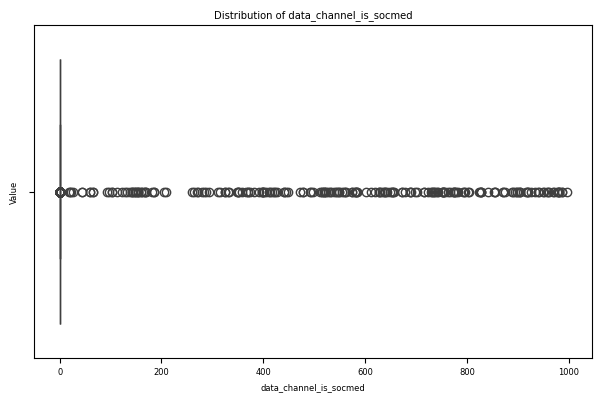

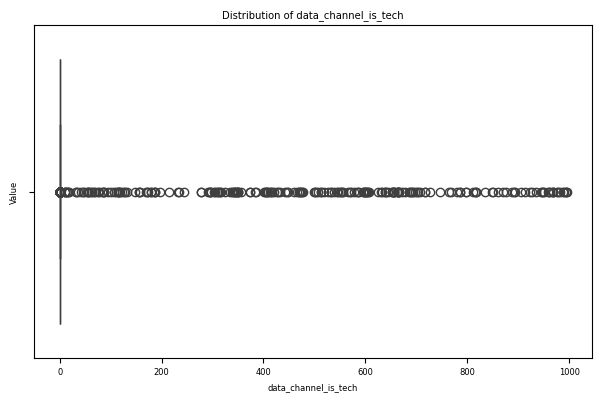

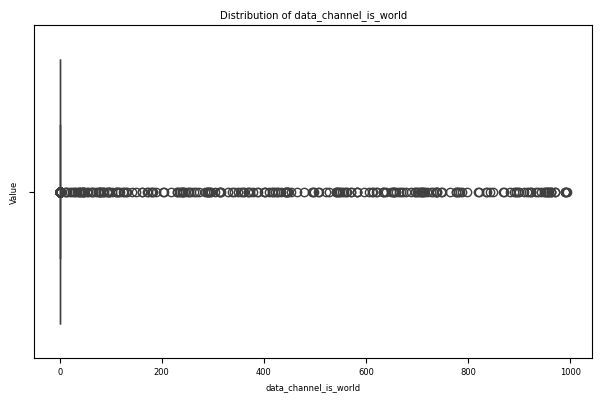

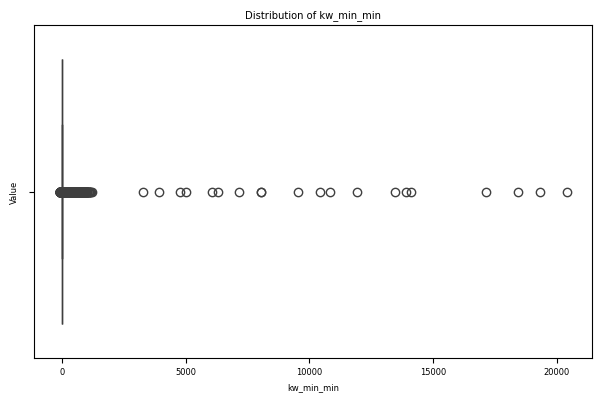

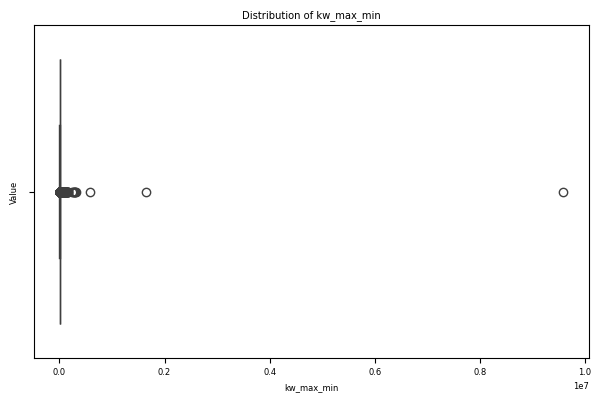

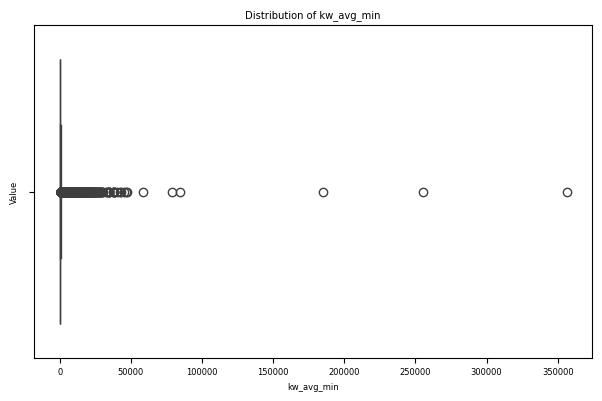

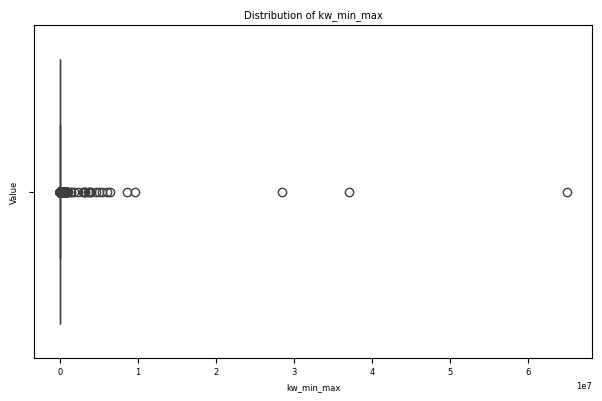

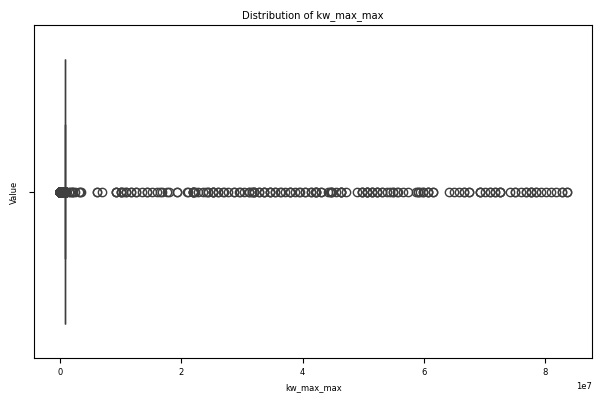

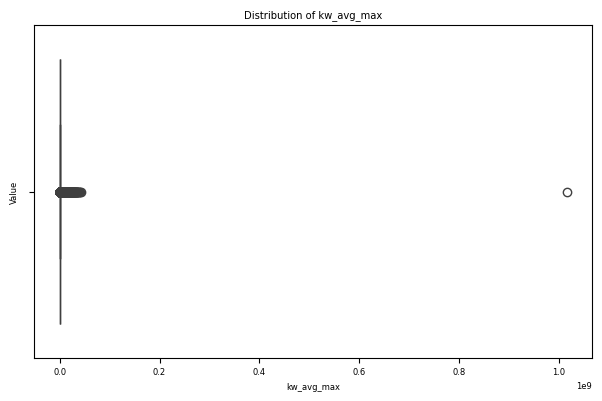

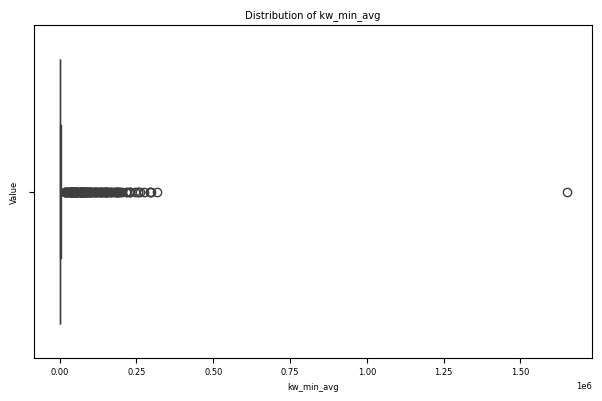

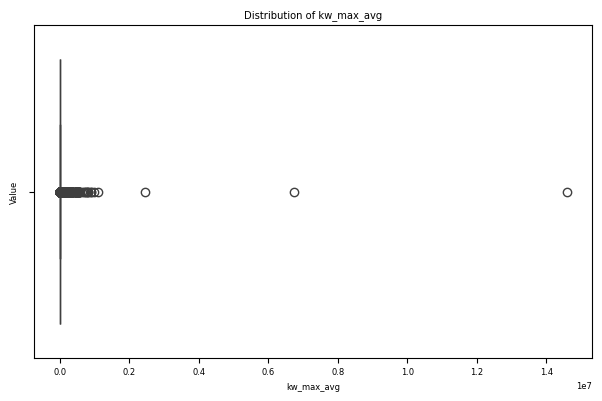

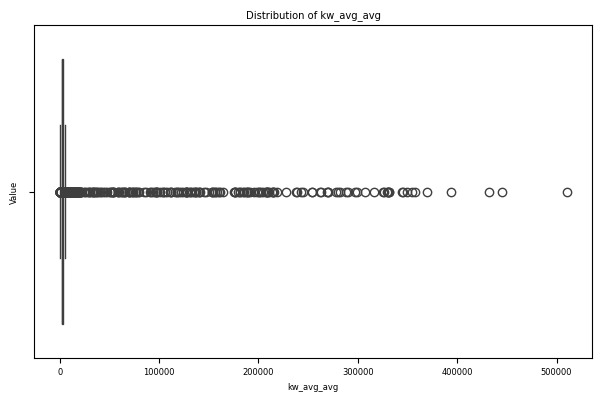

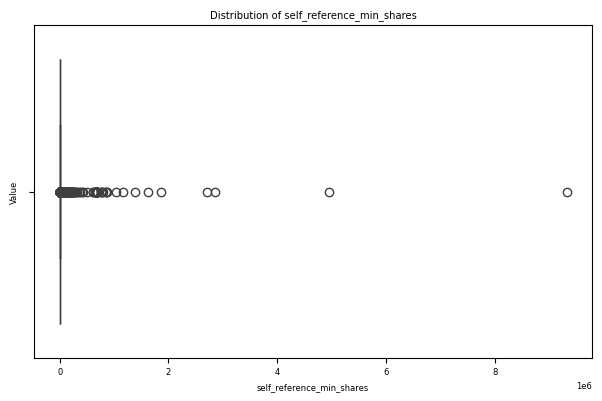

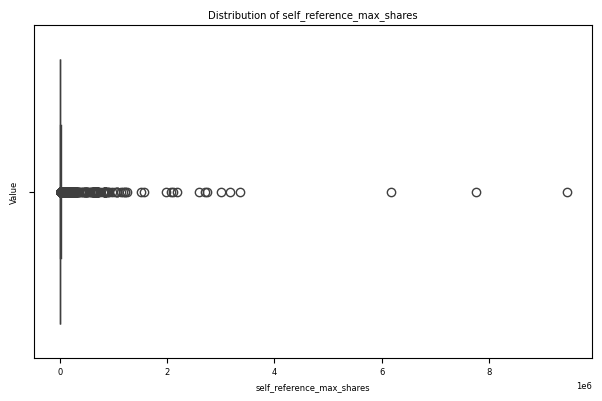

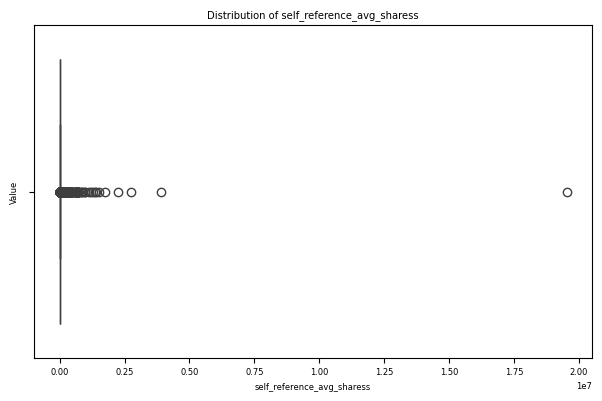

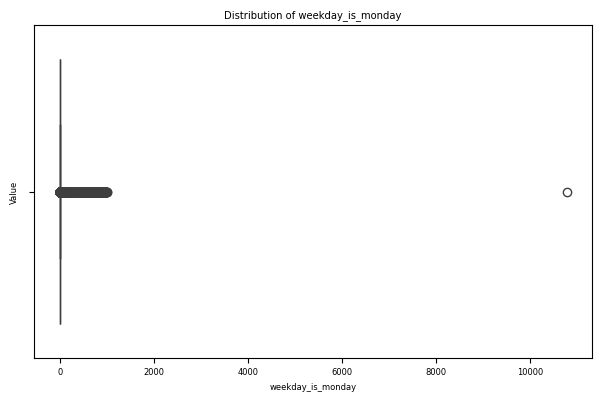

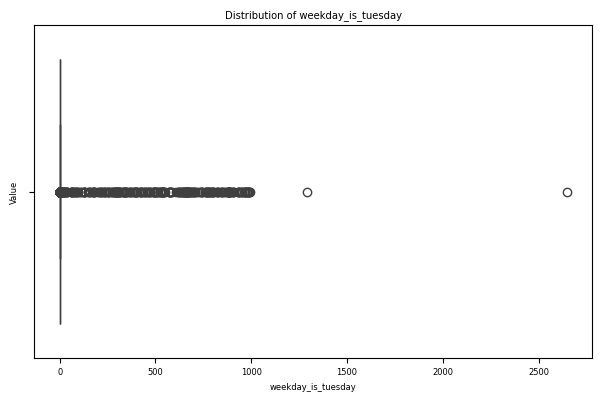

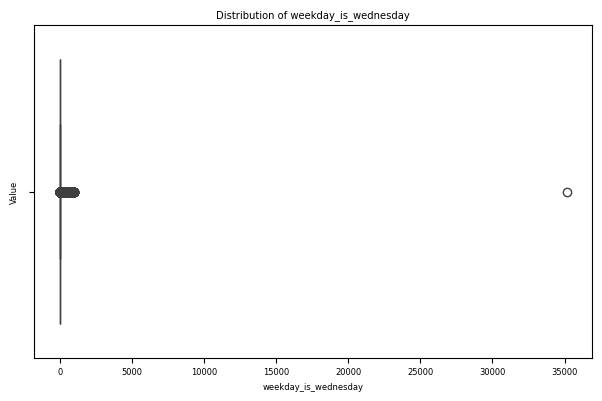

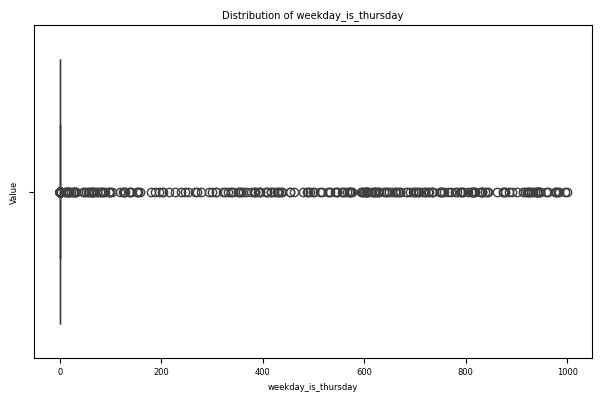

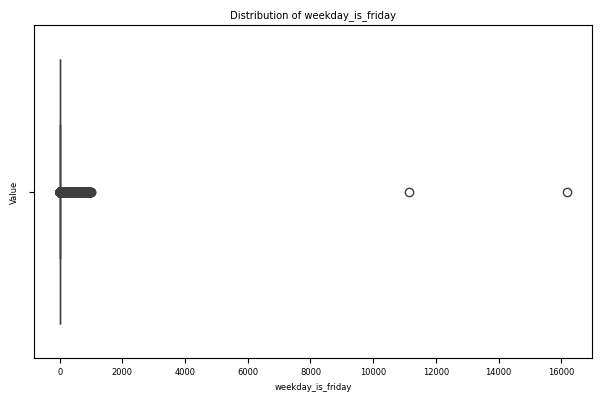

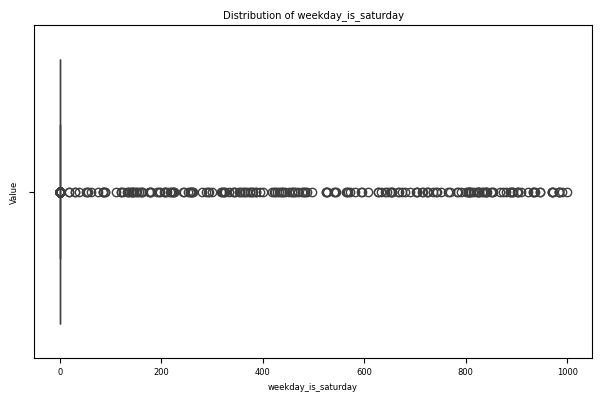

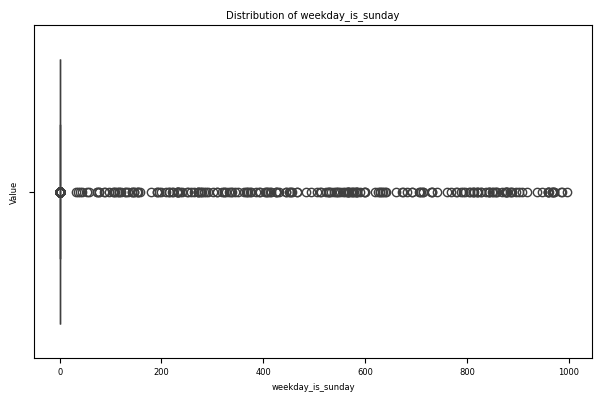

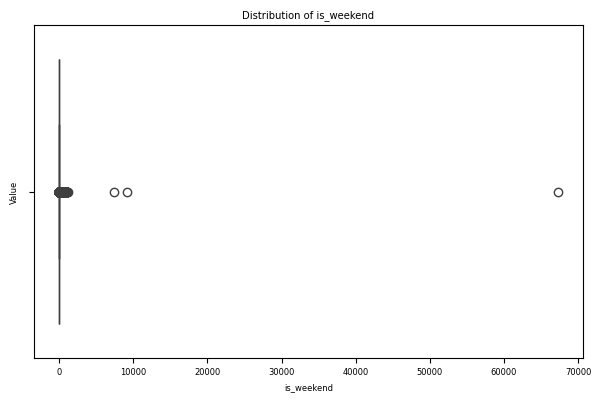

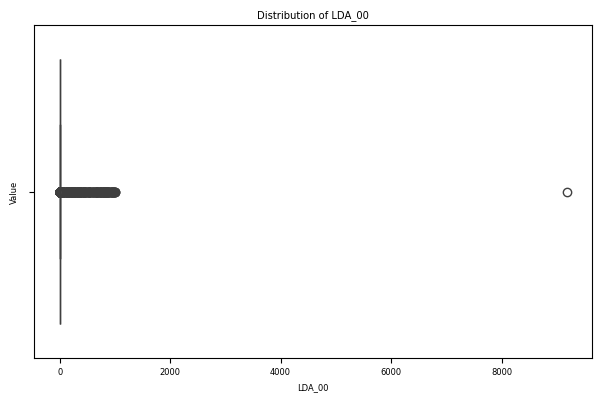

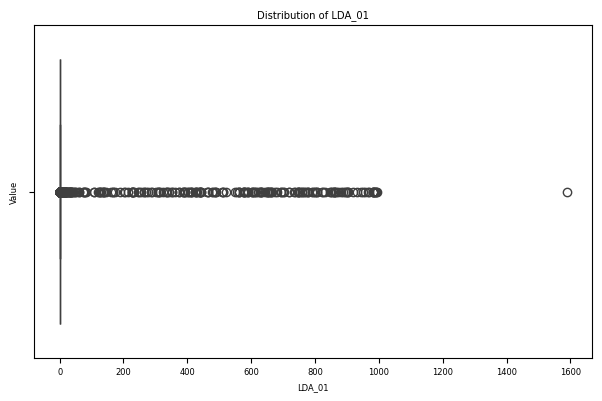

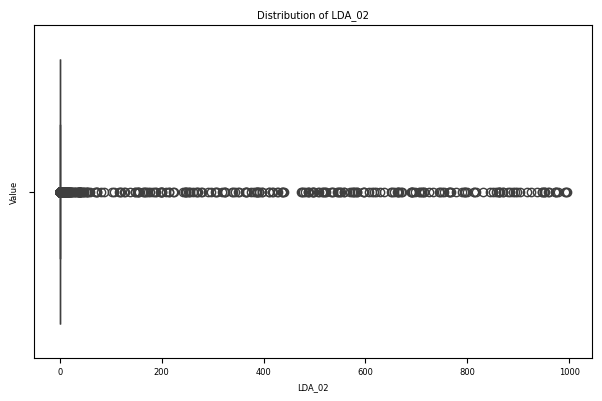

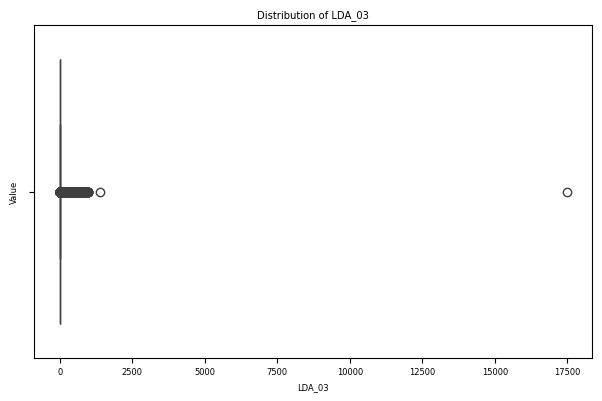

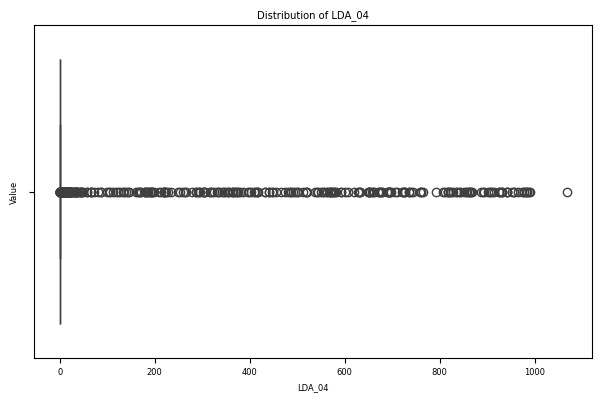

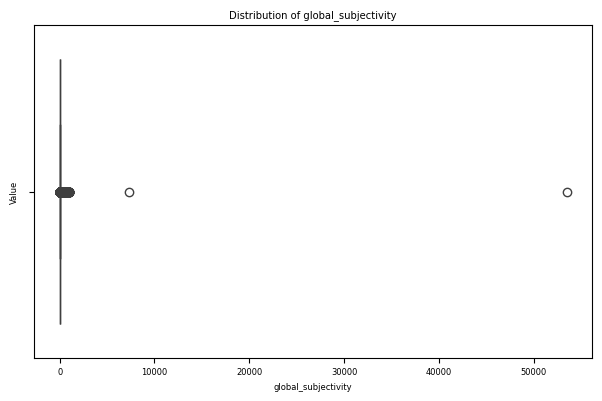

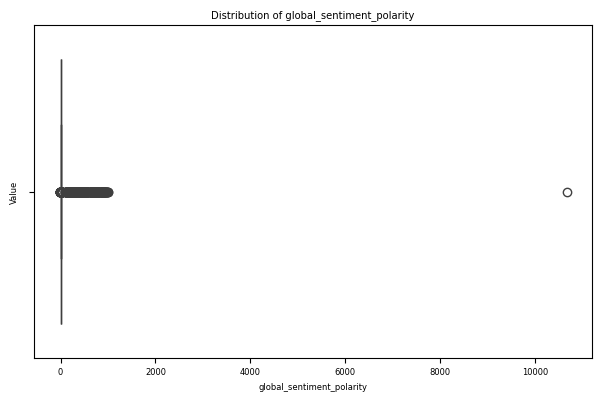

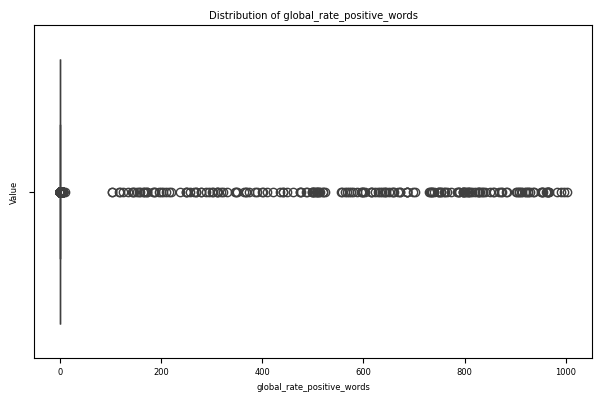

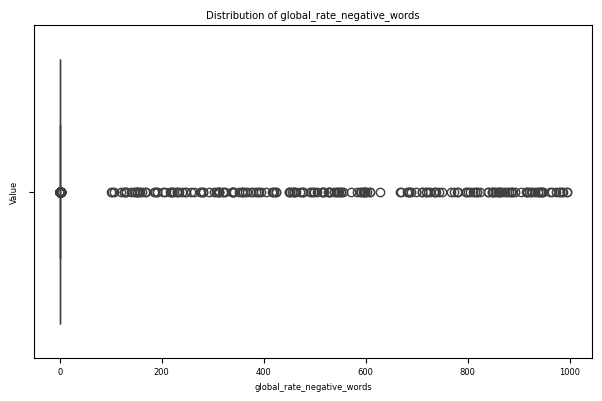

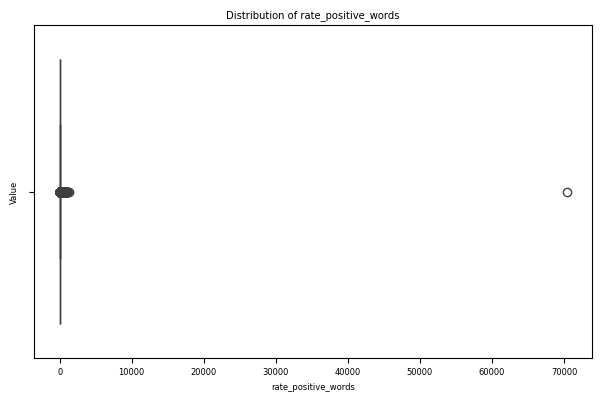

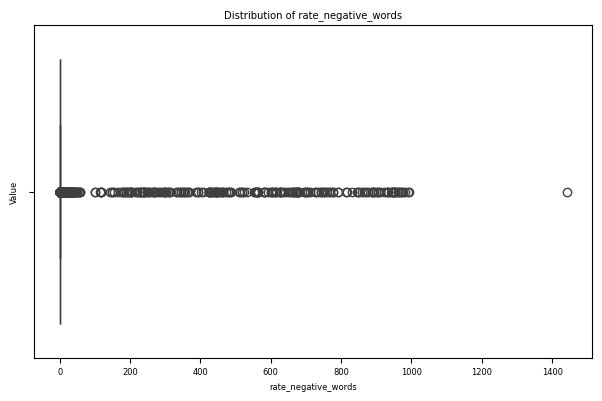

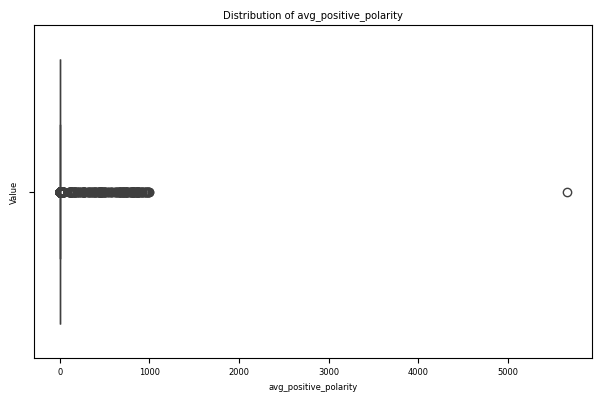

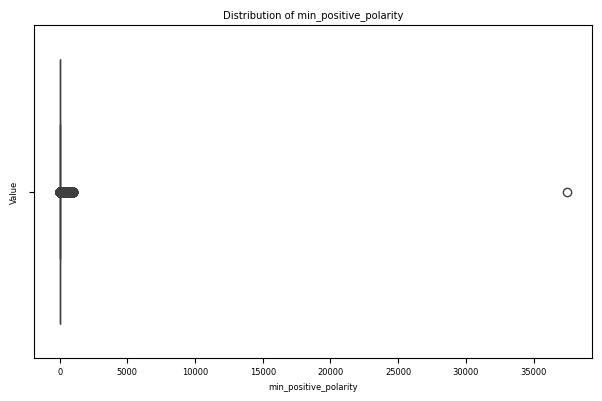

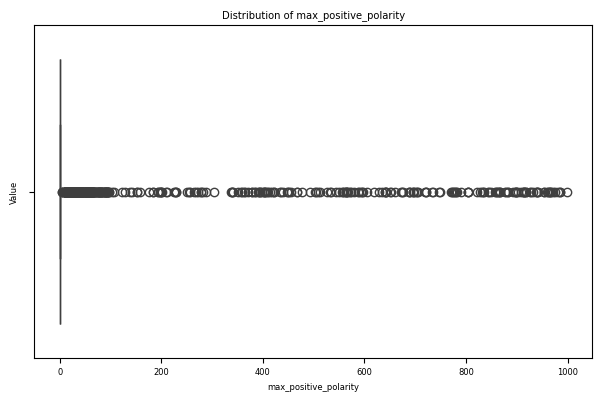

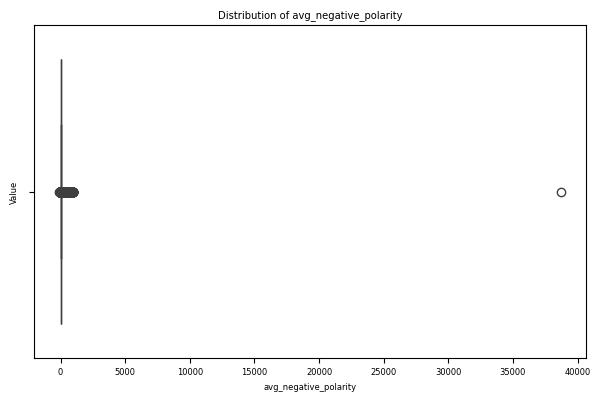

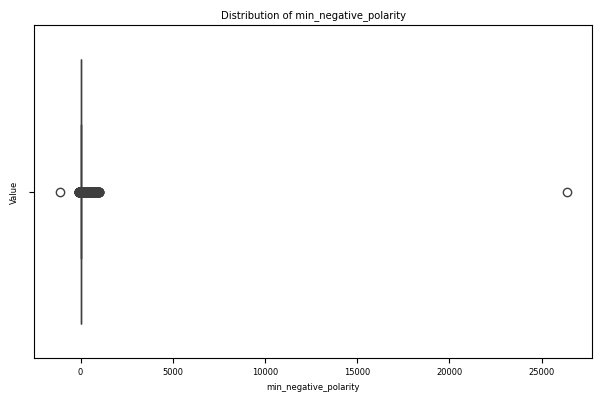

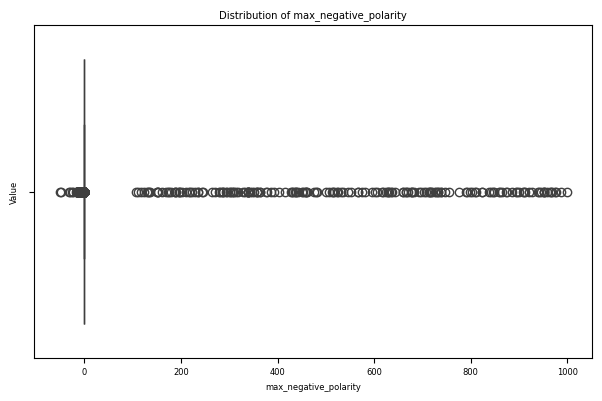

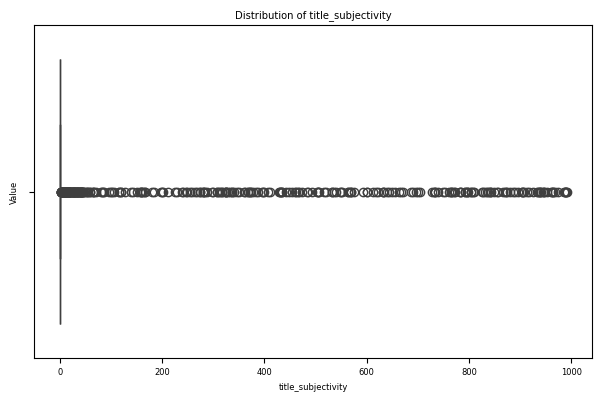

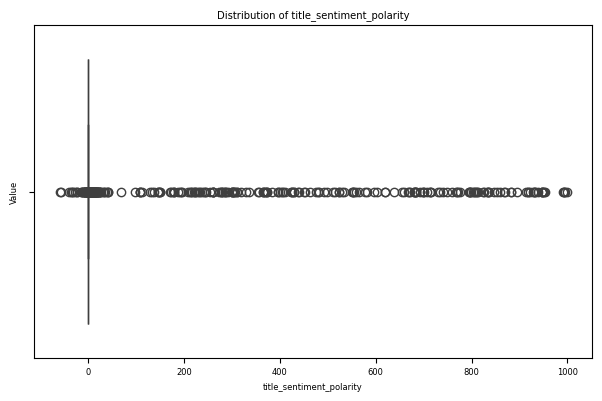

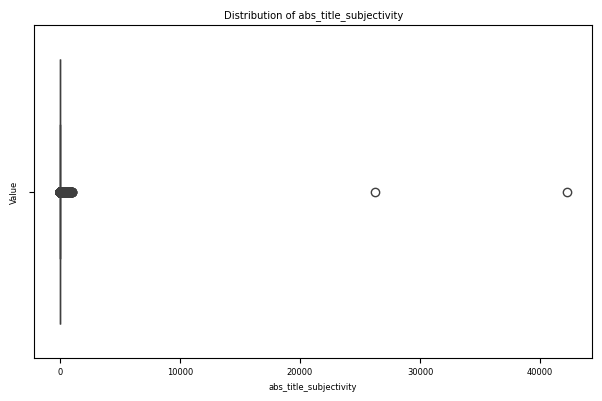

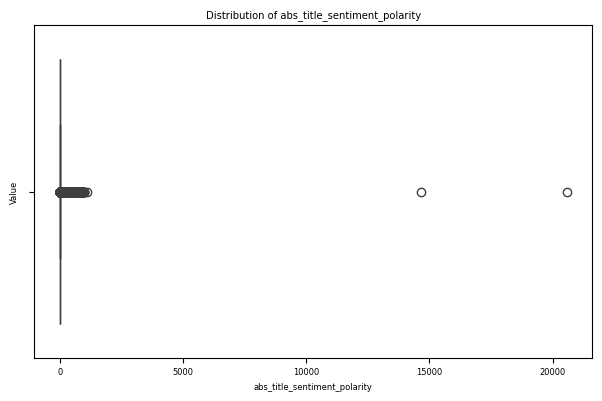

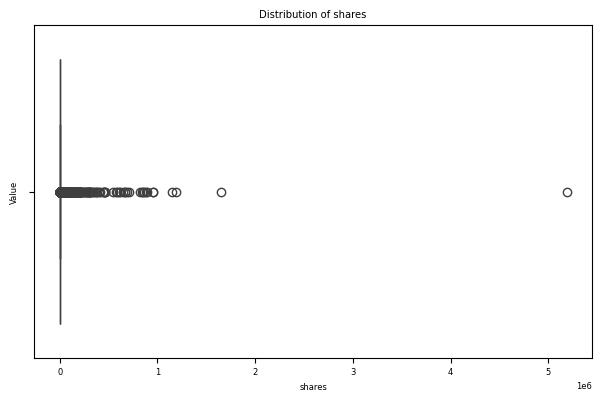

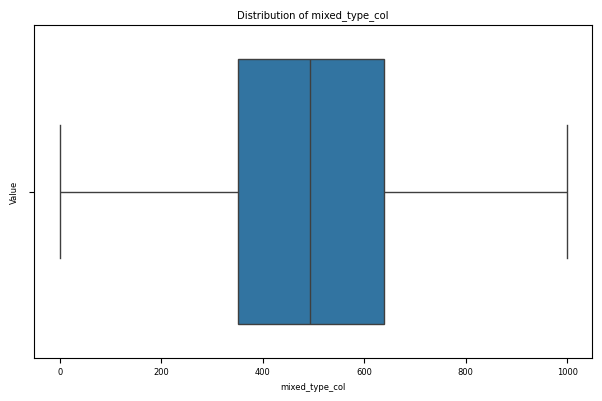

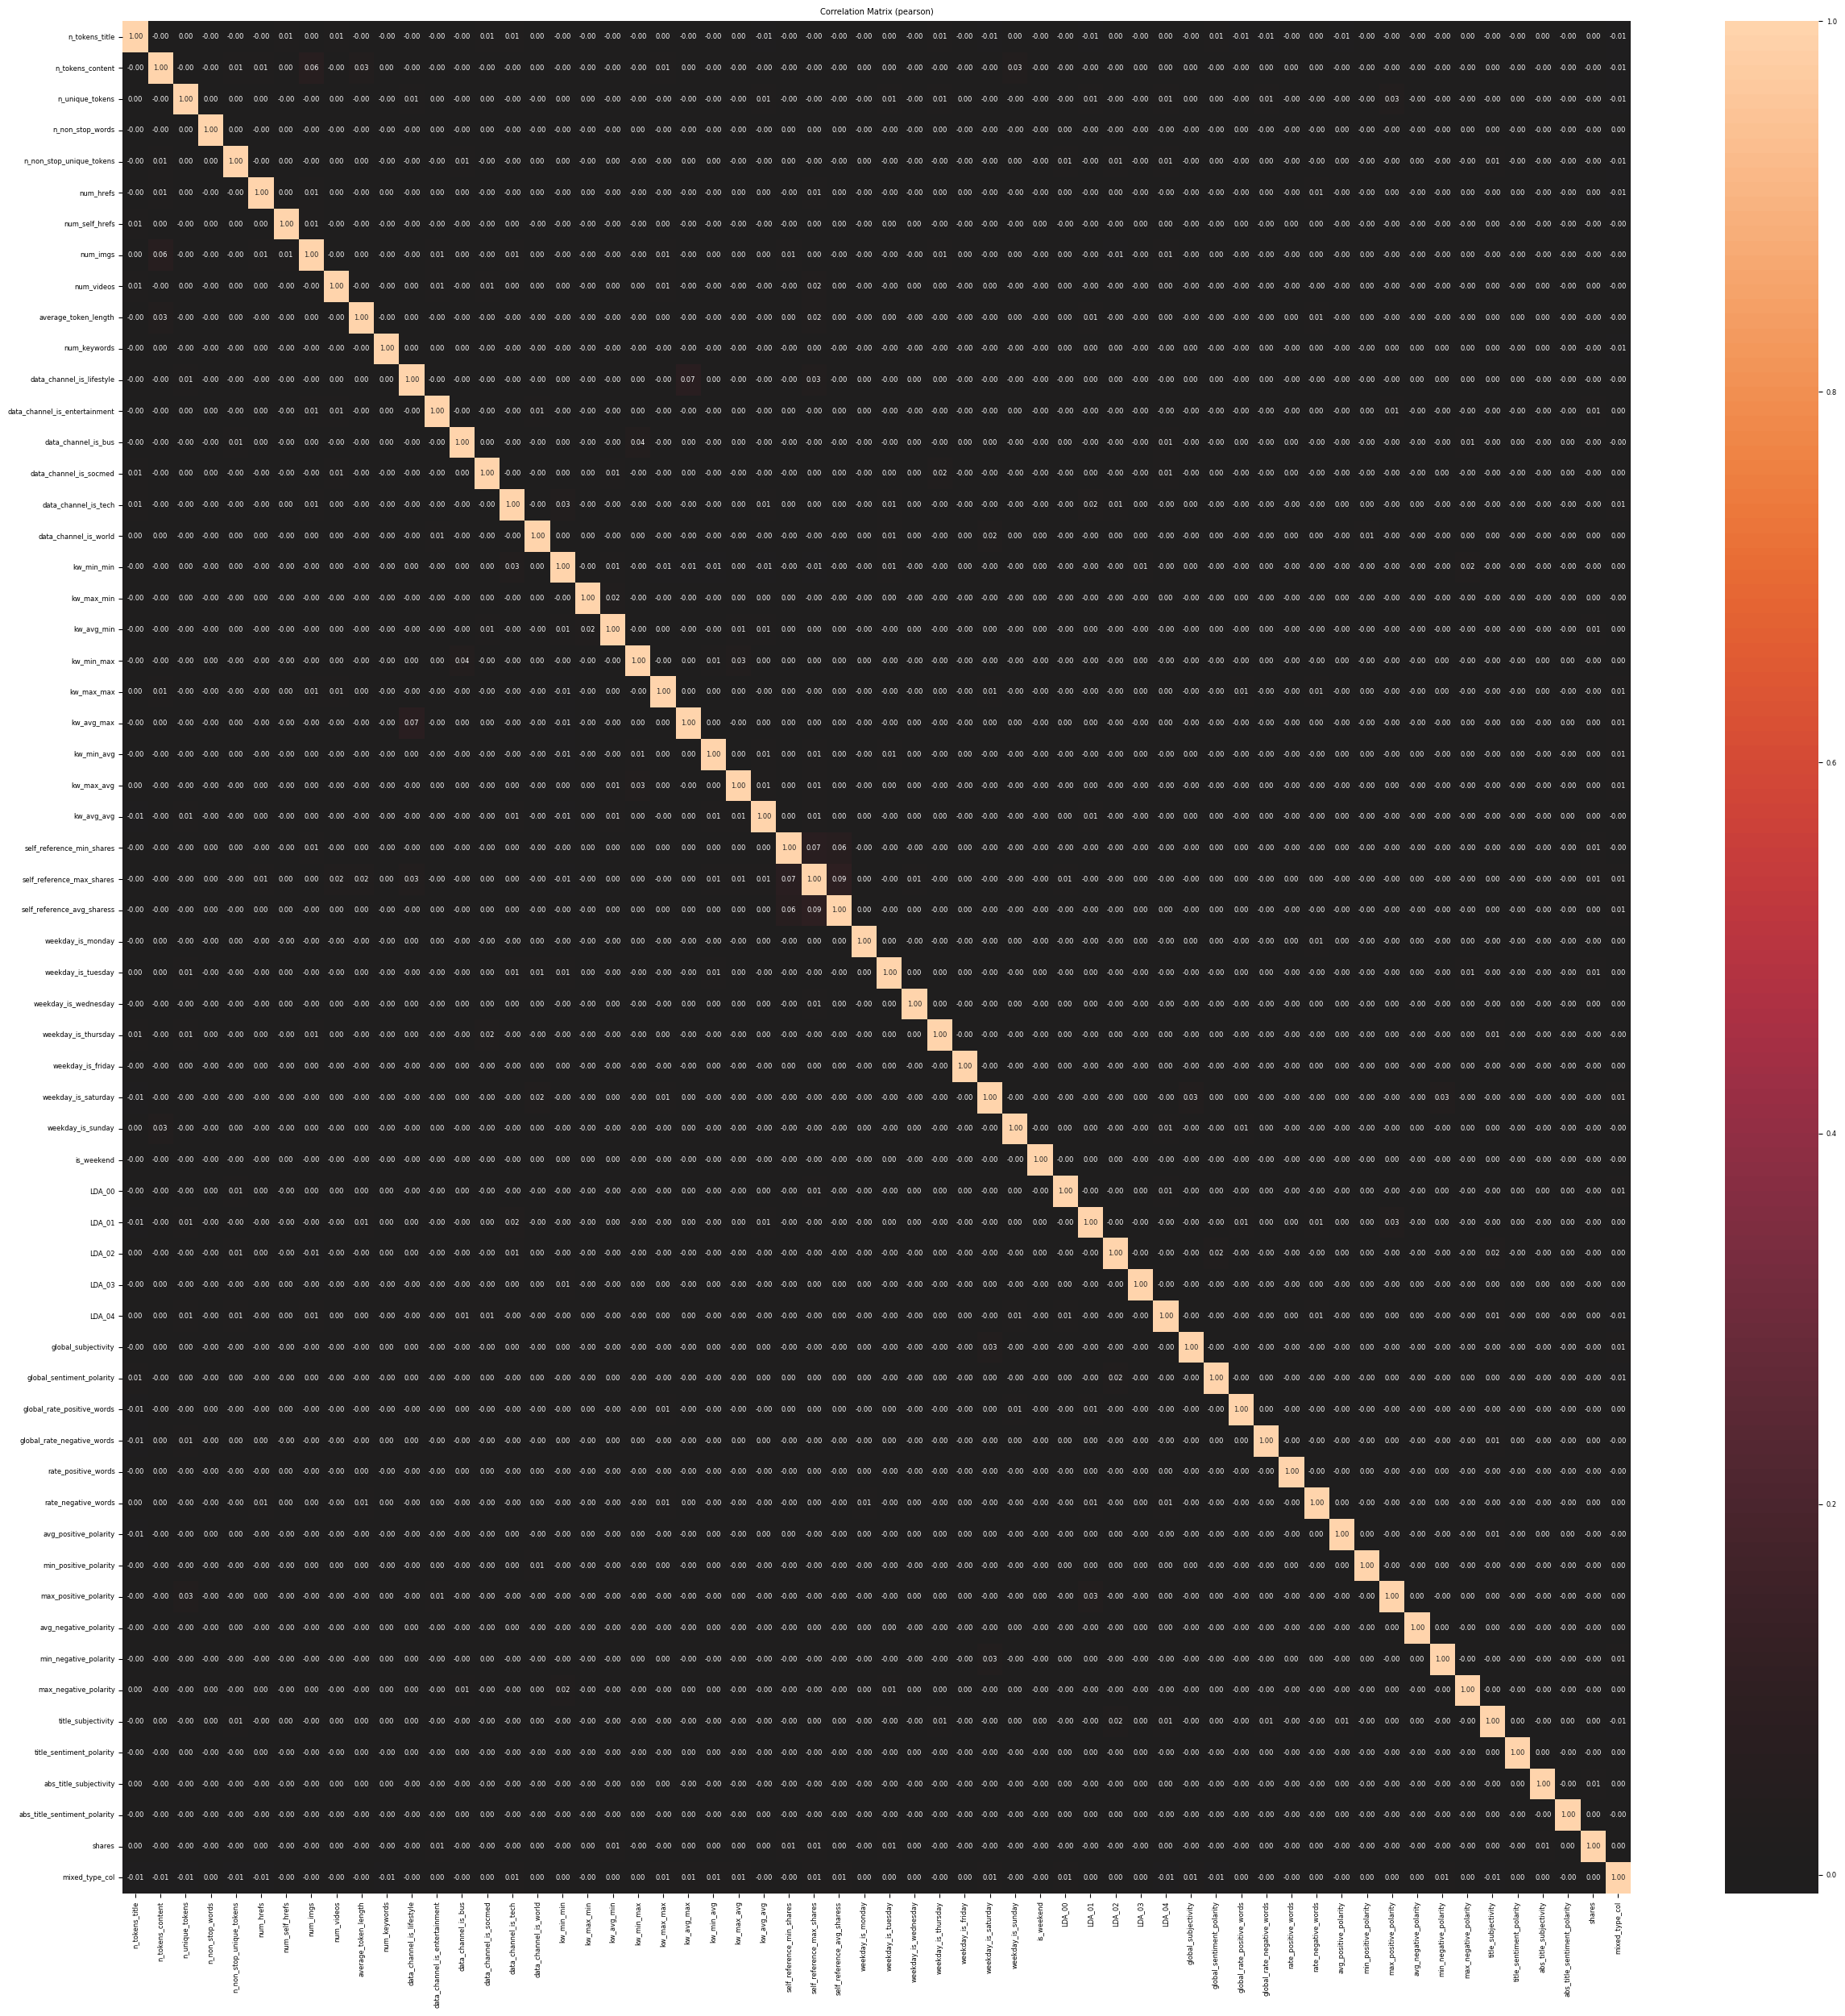

In [25]:
eda = EDAPlotter(df_numeric, corr_method="pearson")
eda.plot_hist("shares", bins=100)
eda.plot_boxplots()                      # o eda.plot_boxplots(["n_tokens_title","num_imgs"])
corr1 = eda.correlation(plot=True)

# **Outliers**

In [27]:
def clip_outliers_iqr(df: pd.DataFrame, 
                      exclude_cols: list[str] = ['shares'], 
                      factor: float = 1.5,
                      verbose: bool = True):
    "Clips outliers in a DataFrame using the IQR method."
    df_clipped = df.copy()
    outlier_percentages = {}

    # Iterar por columnas numéricas
    for col in df_clipped.select_dtypes(include='number').columns:
        if col in exclude_cols:
            continue

        Q1 = df_clipped[col].quantile(0.25)
        Q3 = df_clipped[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR

        # Detectar outliers
        outliers = df_clipped[(df_clipped[col] < lower_bound) | (df_clipped[col] > upper_bound)]
        percentage = (len(outliers) / len(df_clipped)) * 100
        outlier_percentages[col] = percentage

        # Aplicar clipping
        df_clipped[col] = df_clipped[col].clip(lower=lower_bound, upper=upper_bound)

    # Calcular promedio de outliers
    mean_percentage = sum(outlier_percentages.values()) / len(outlier_percentages) if outlier_percentages else 0

    # Mostrar resultados si verbose=True
    if verbose:
        print("Porcentaje de outliers por columna:")
        for col, pct in outlier_percentages.items():
            print(f"  {col:25s}: {pct:6.2f}%")
        print(f"\nPromedio de porcentaje de outliers: {mean_percentage:.2f}%")

    return df_clipped, outlier_percentages, mean_percentage

In [33]:
df_numeric, outlier_stats, mean_outliers = clip_outliers_iqr(df_numeric, exclude_cols=['shares'])

Porcentaje de outliers por columna:
  n_tokens_title           :   1.41%
  n_tokens_content         :   5.29%
  n_unique_tokens          :   4.98%
  n_non_stop_words         :   8.14%
  n_non_stop_unique_tokens :   5.27%
  num_hrefs                :   6.33%
  num_self_hrefs           :   6.08%
  num_imgs                 :  19.81%
  num_videos               :   7.86%
  average_token_length     :   5.13%
  num_keywords             :   1.11%
  data_channel_is_lifestyle:   5.70%
  data_channel_is_entertainment:  17.90%
  data_channel_is_bus      :  16.01%
  data_channel_is_socmed   :   6.23%
  data_channel_is_tech     :  18.59%
  data_channel_is_world    :  21.30%
  kw_min_min               :  12.44%
  kw_max_min               :   9.58%
  kw_avg_min               :   5.92%
  kw_min_max               :  12.87%
  kw_max_max               :  24.15%
  kw_avg_max               :   2.96%
  kw_min_avg               :   0.31%
  kw_max_avg               :   6.38%
  kw_avg_avg               :   4.49

# **EDA p.II**

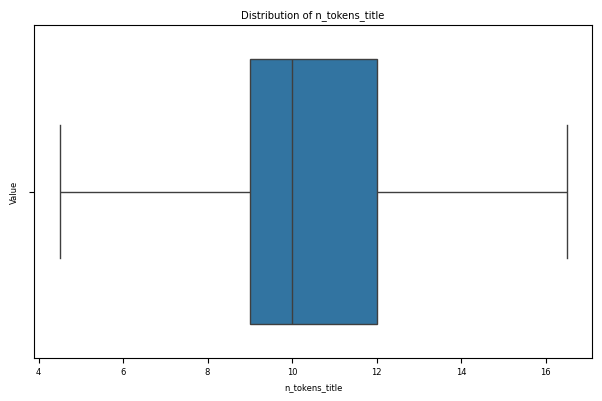

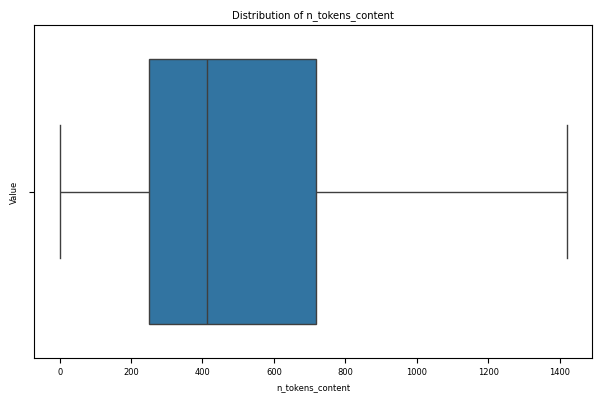

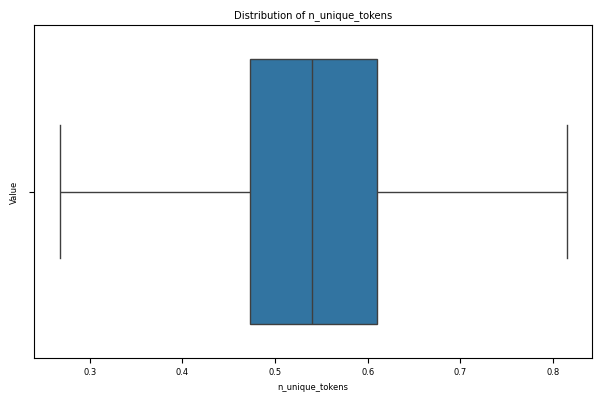

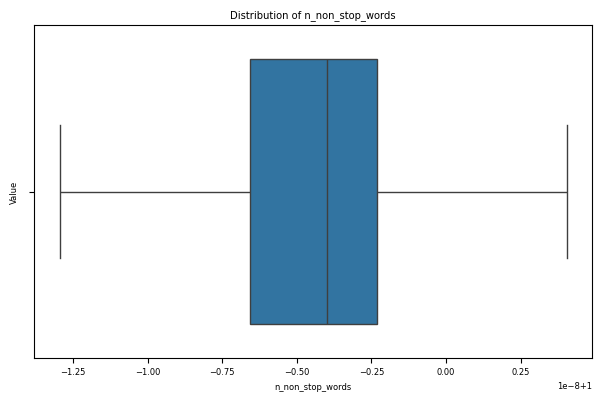

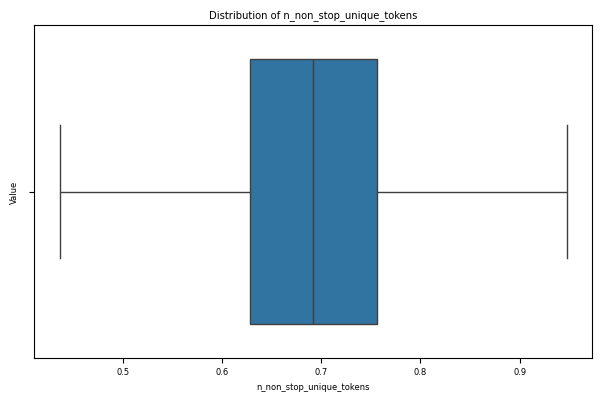

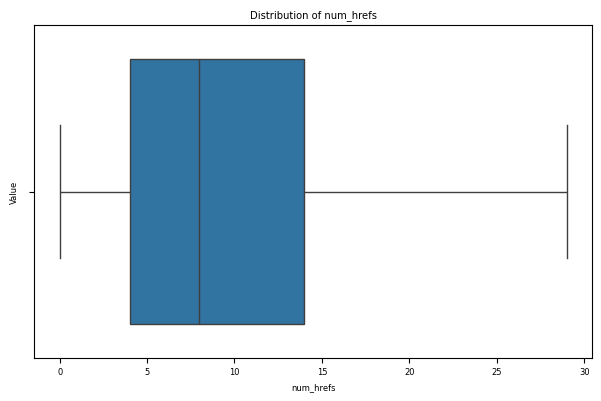

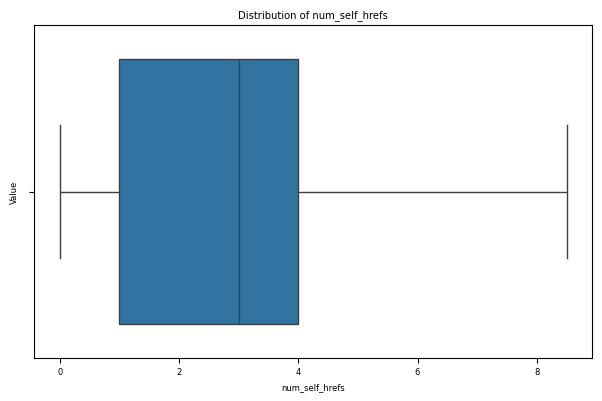

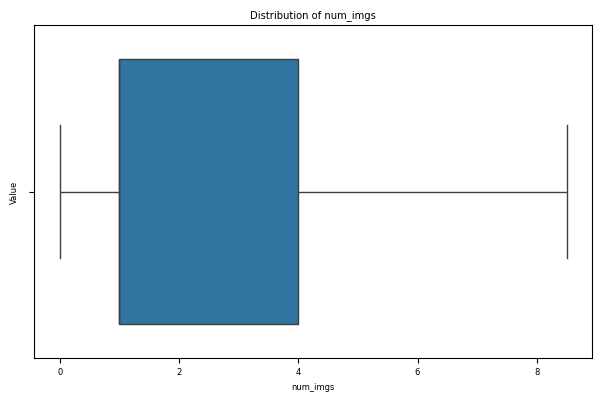

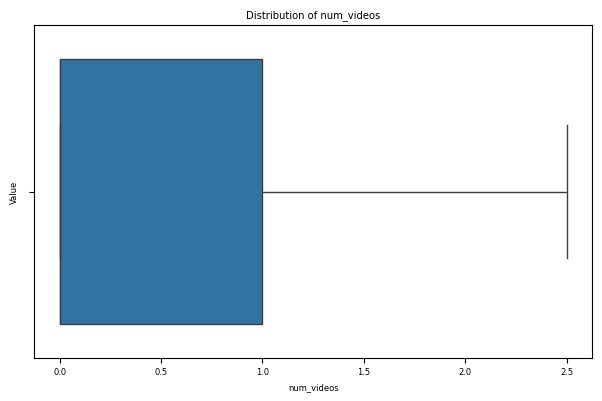

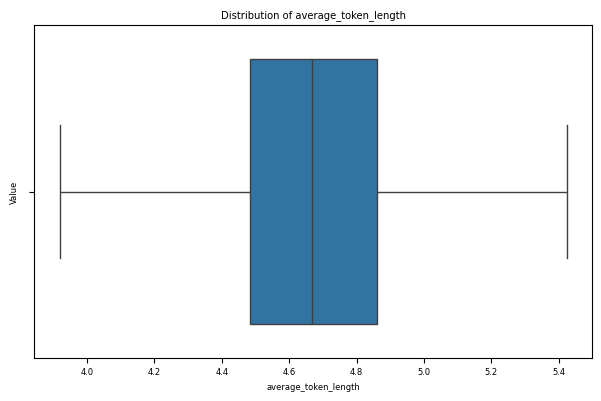

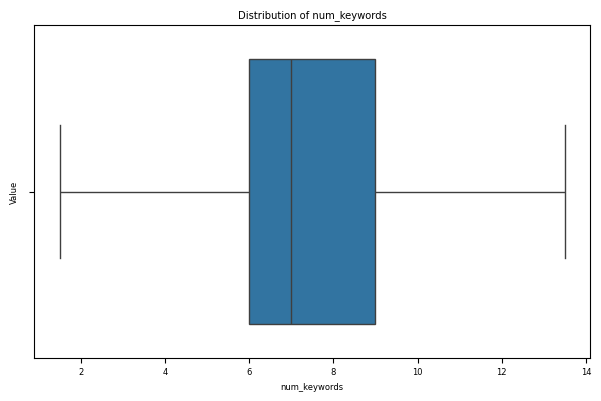

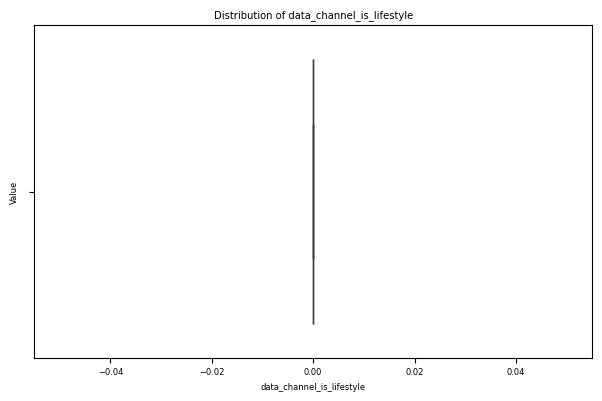

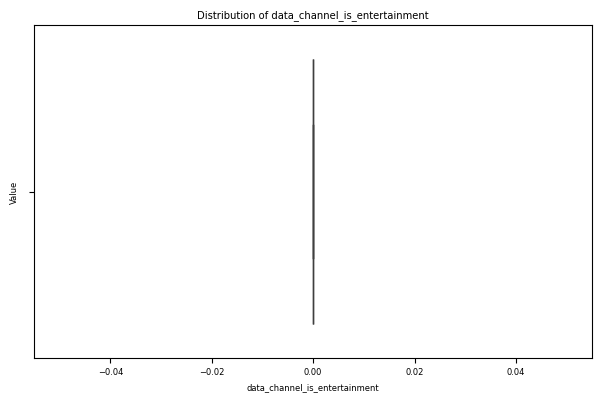

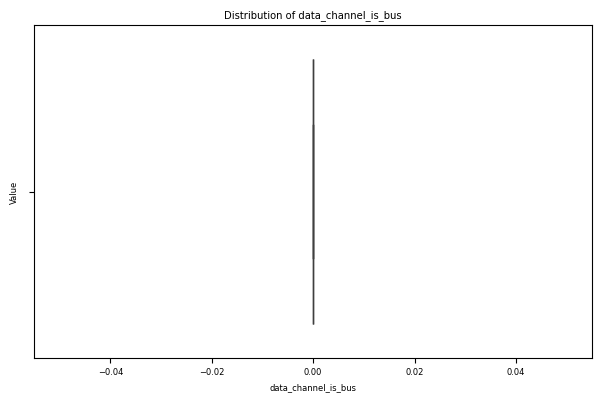

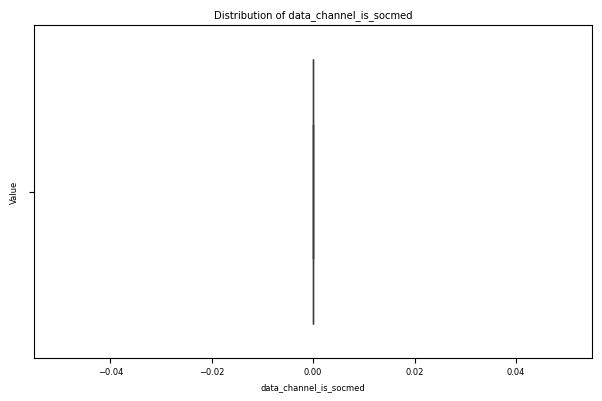

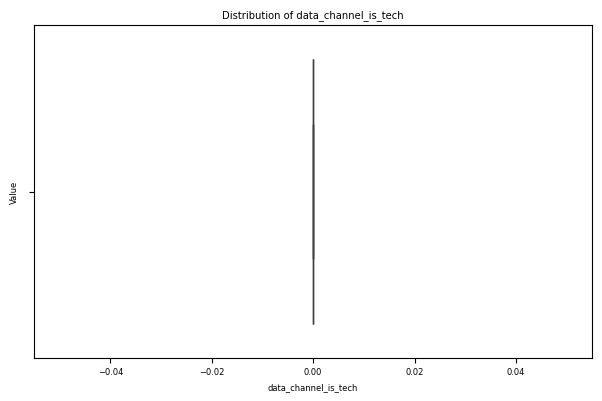

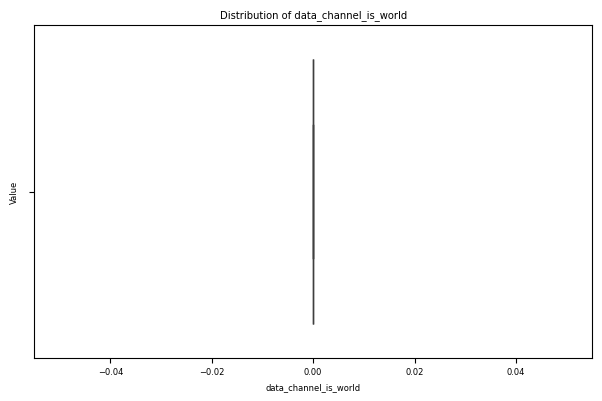

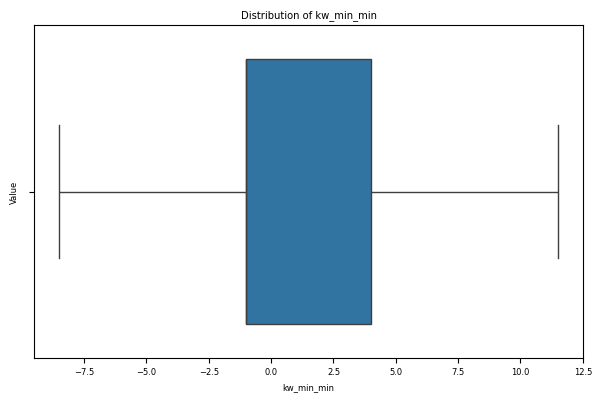

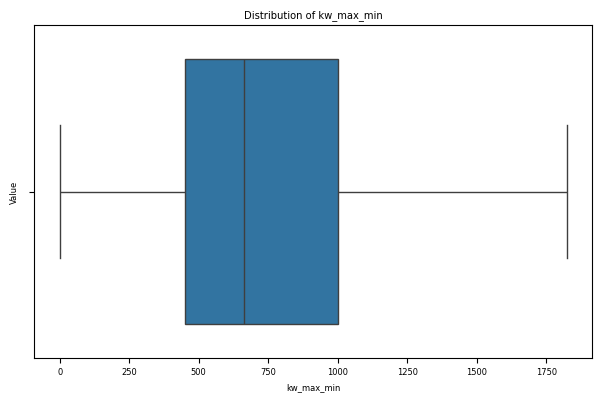

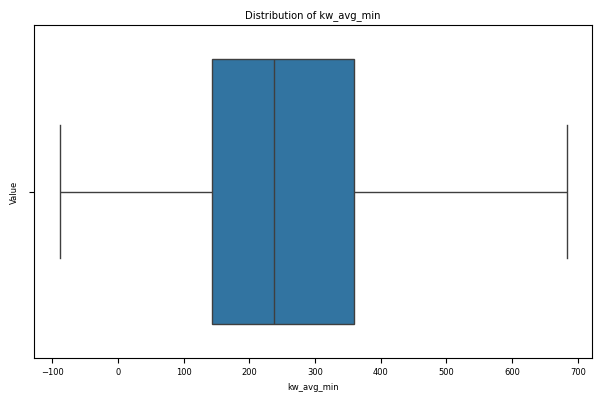

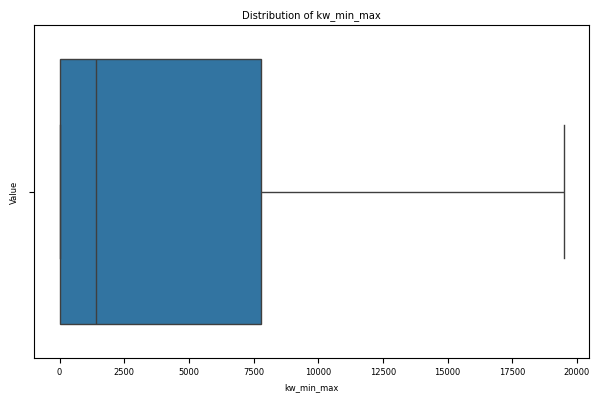

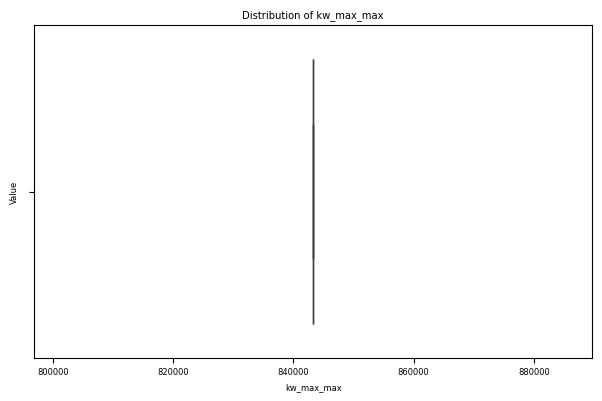

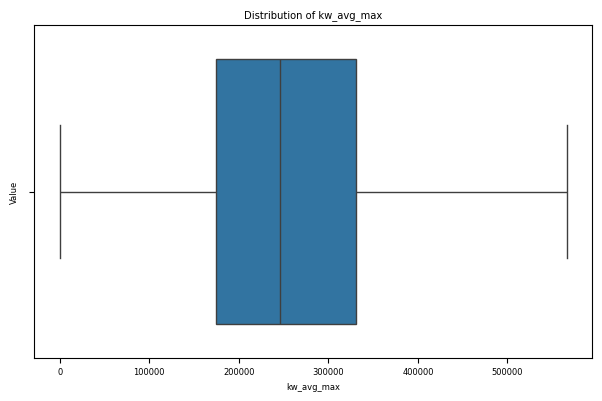

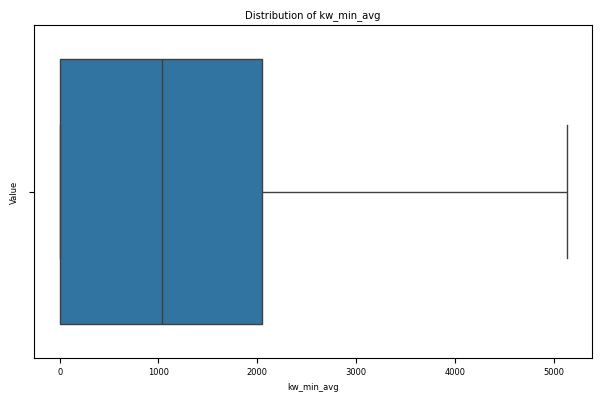

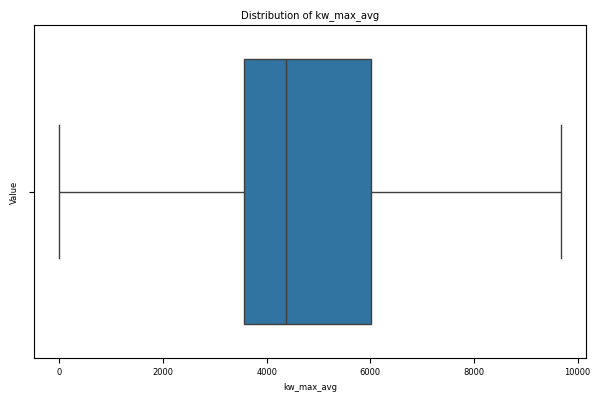

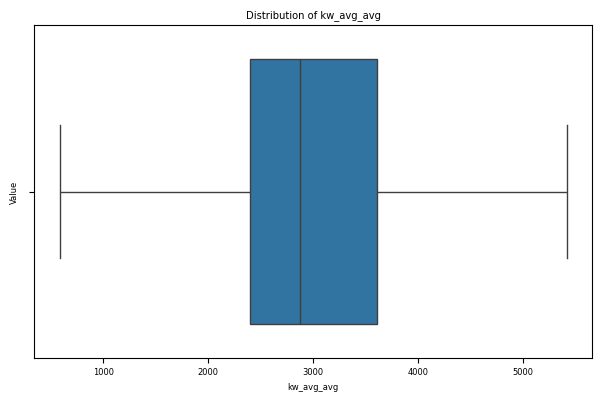

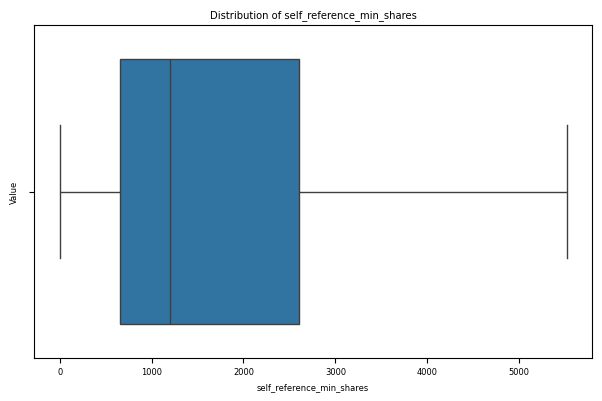

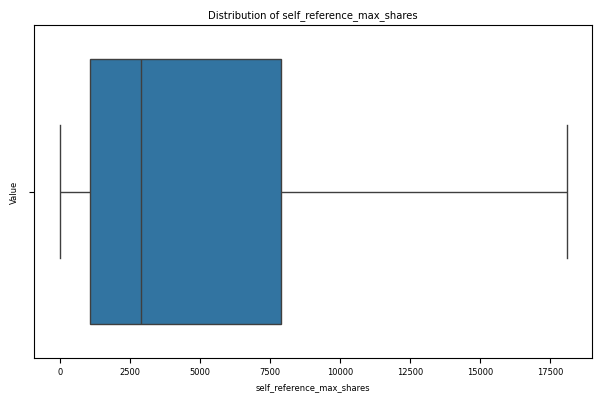

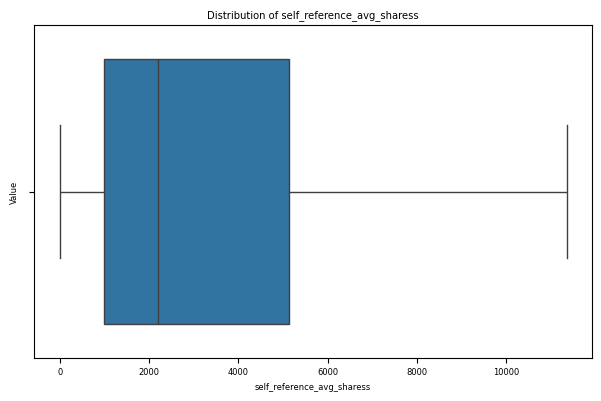

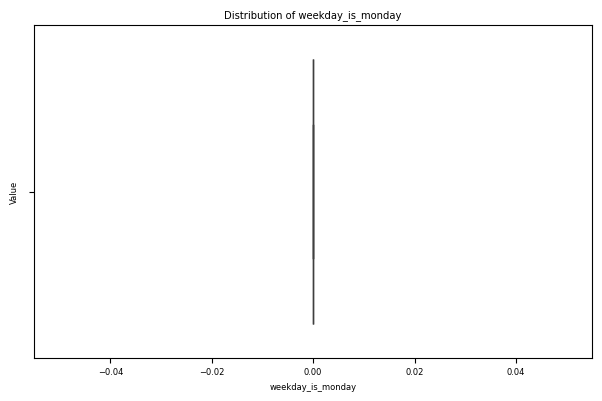

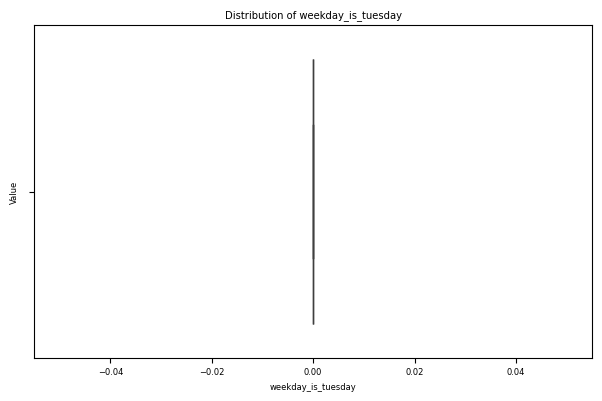

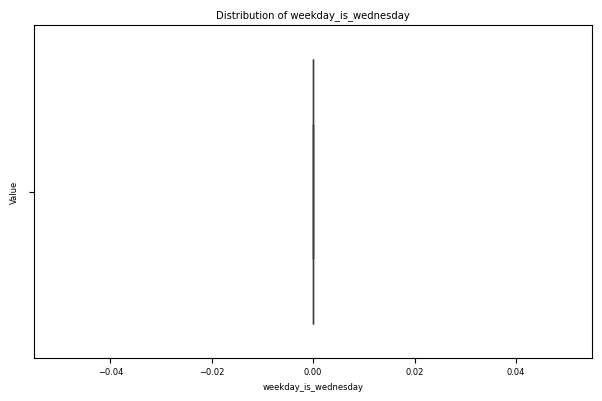

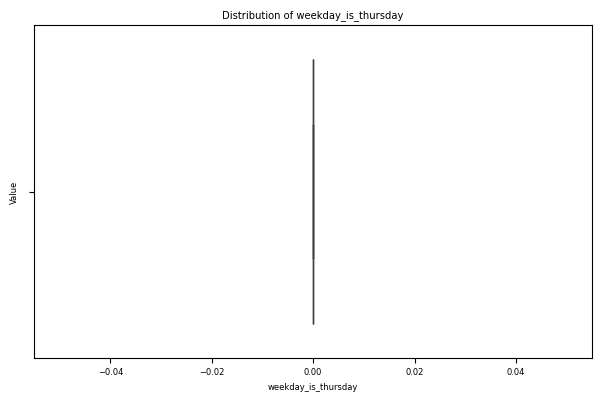

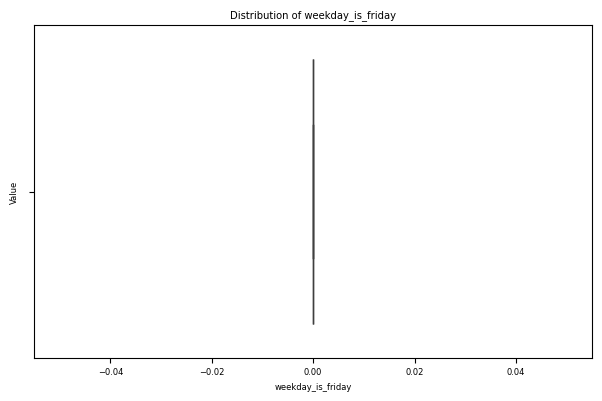

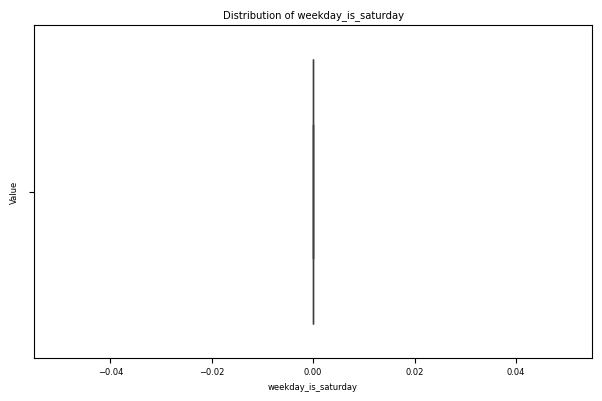

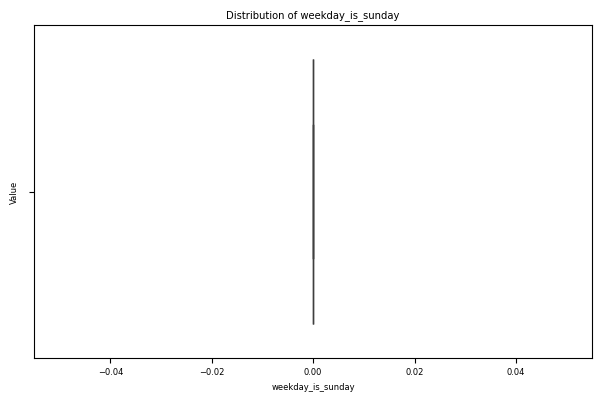

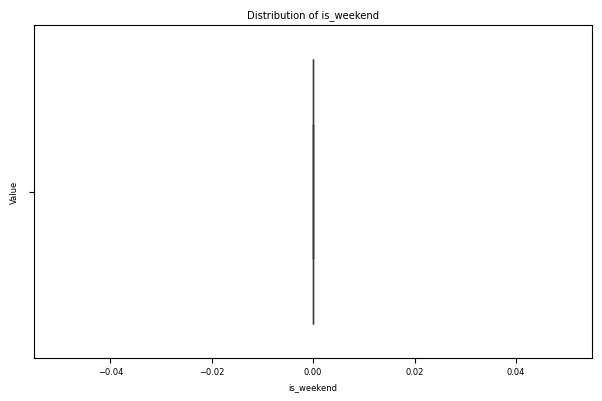

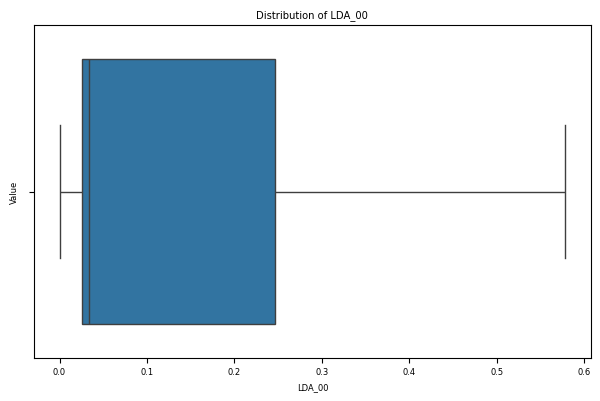

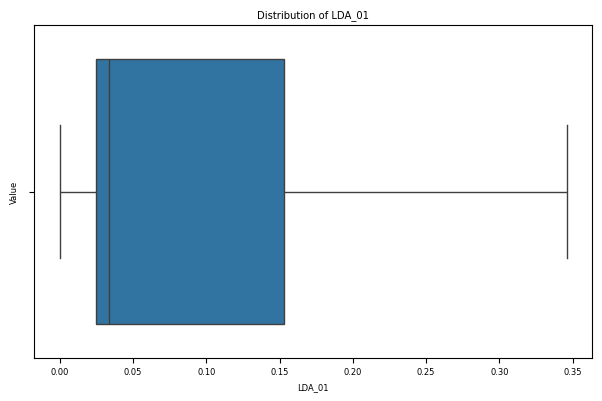

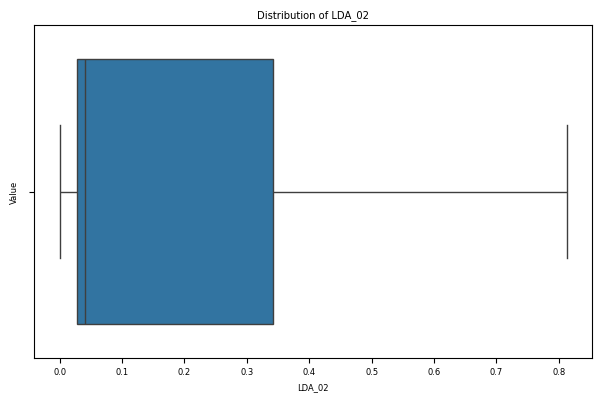

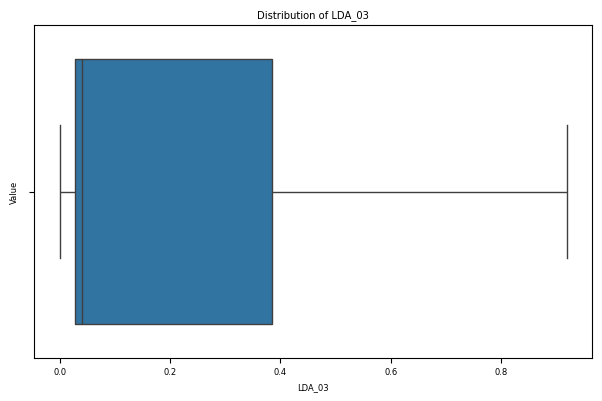

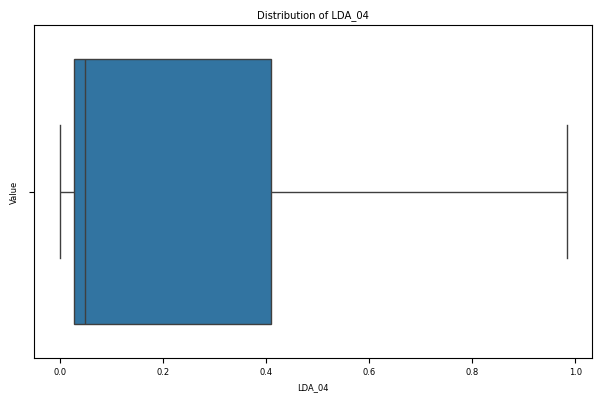

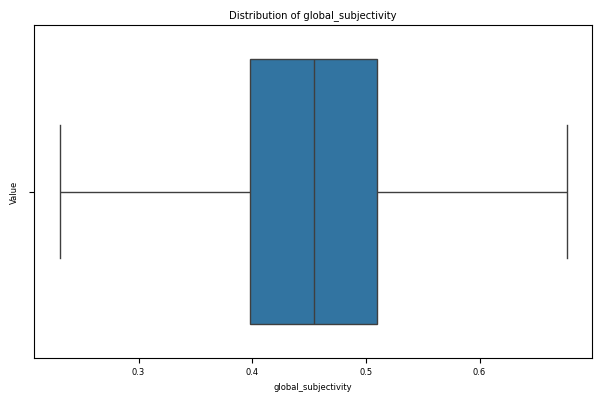

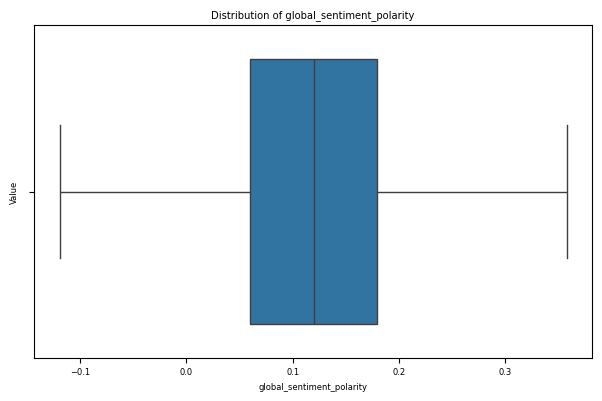

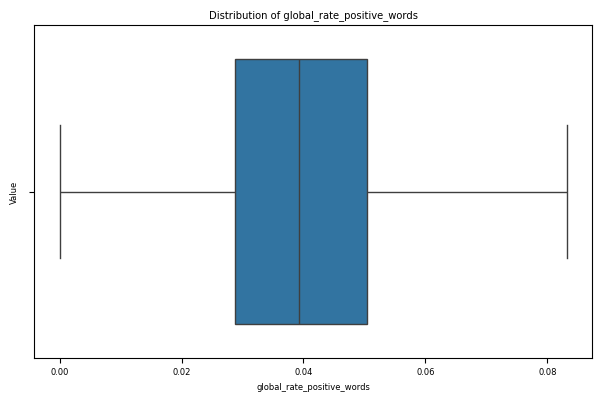

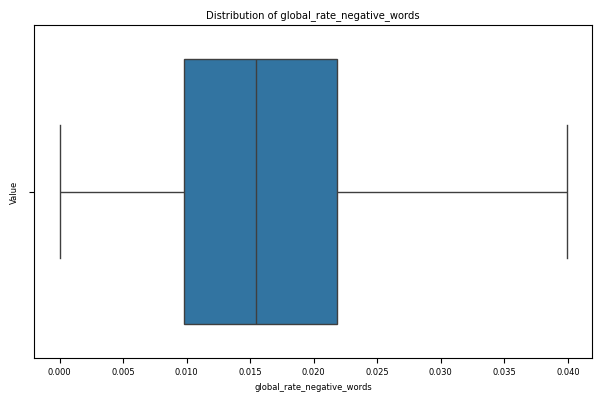

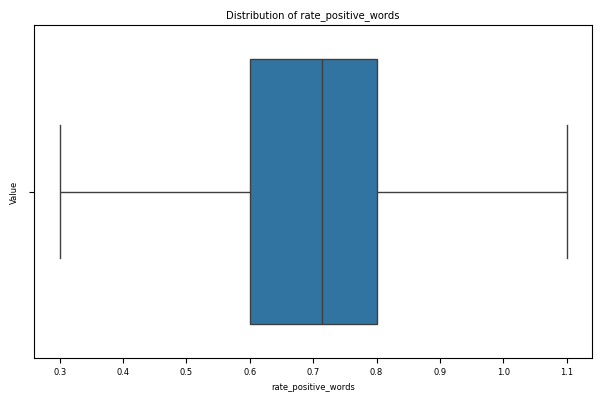

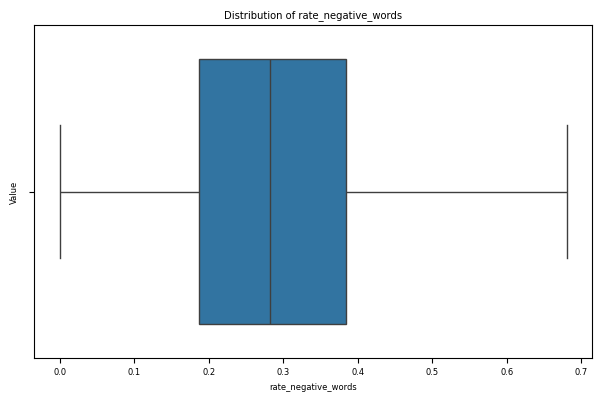

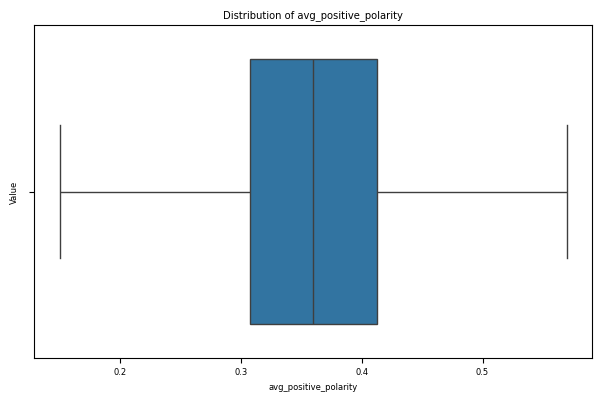

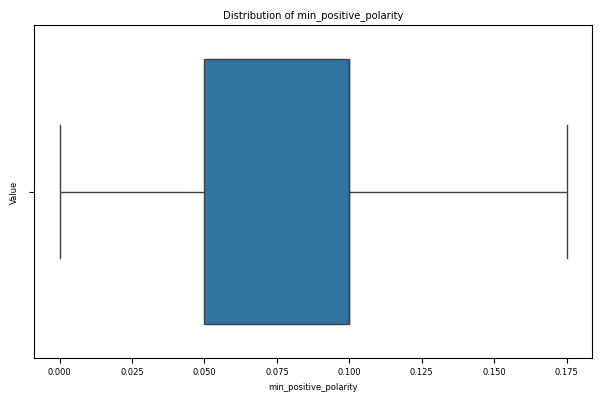

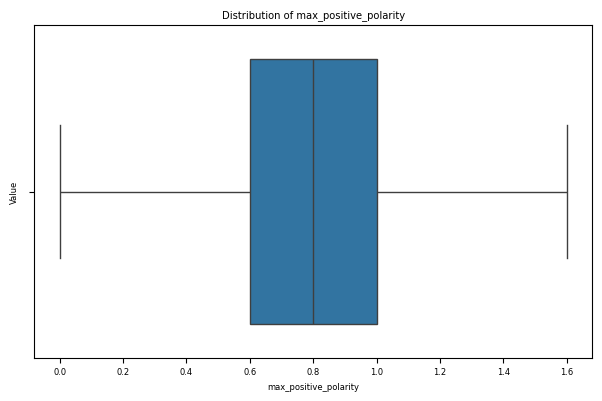

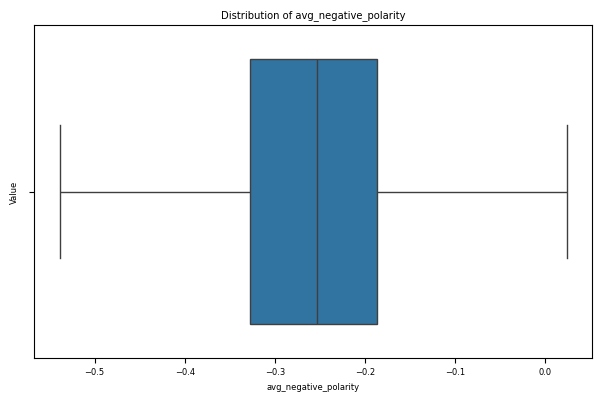

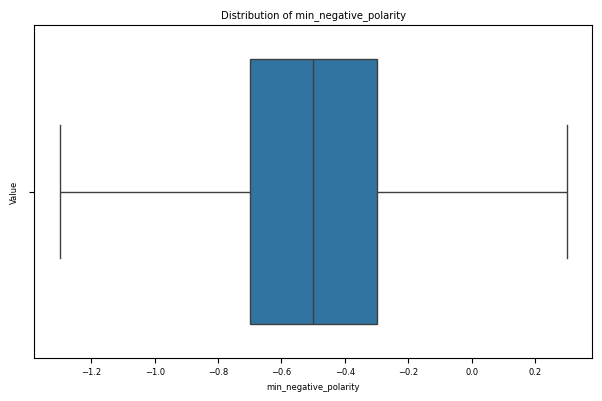

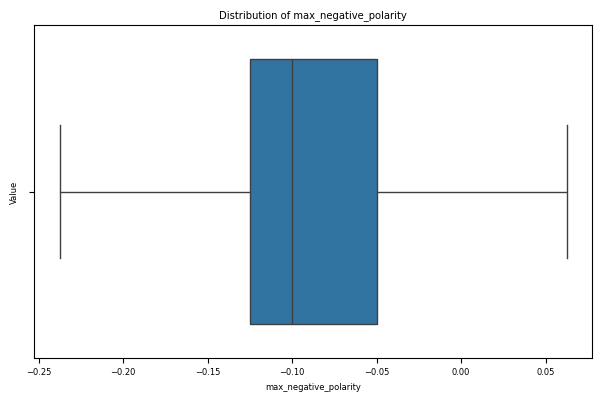

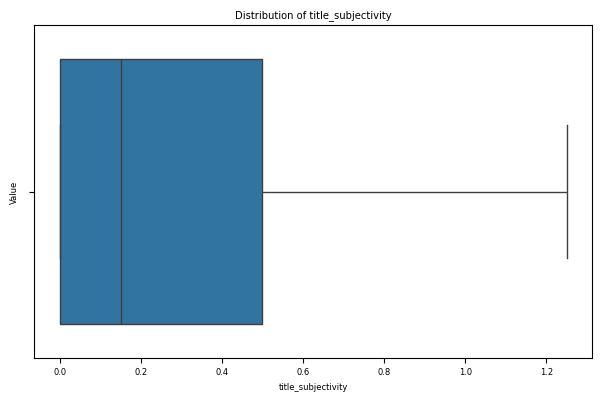

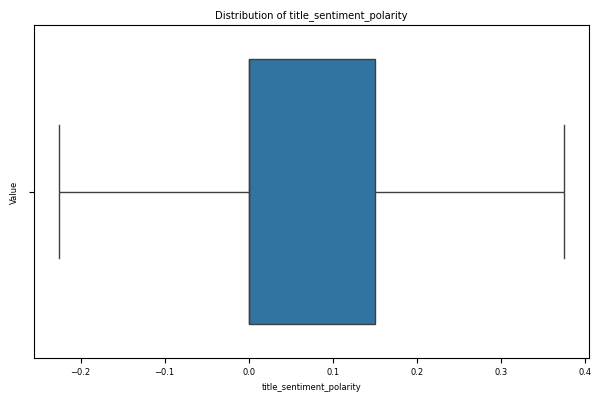

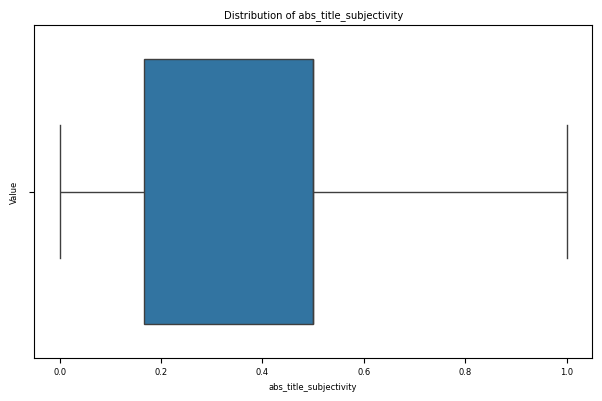

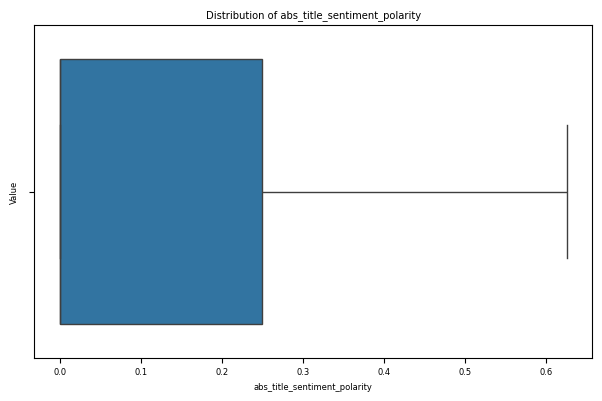

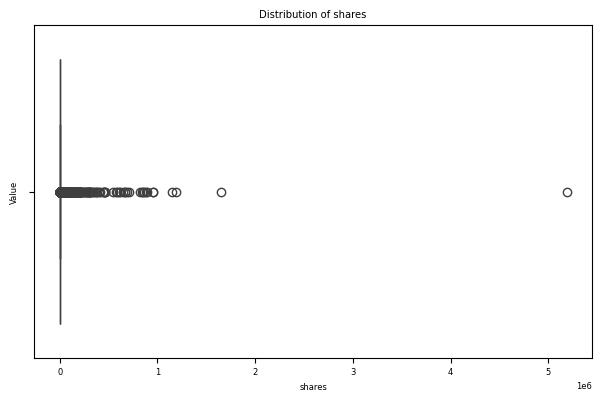

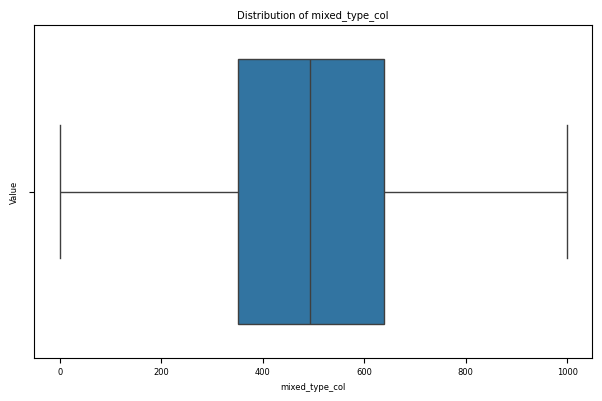

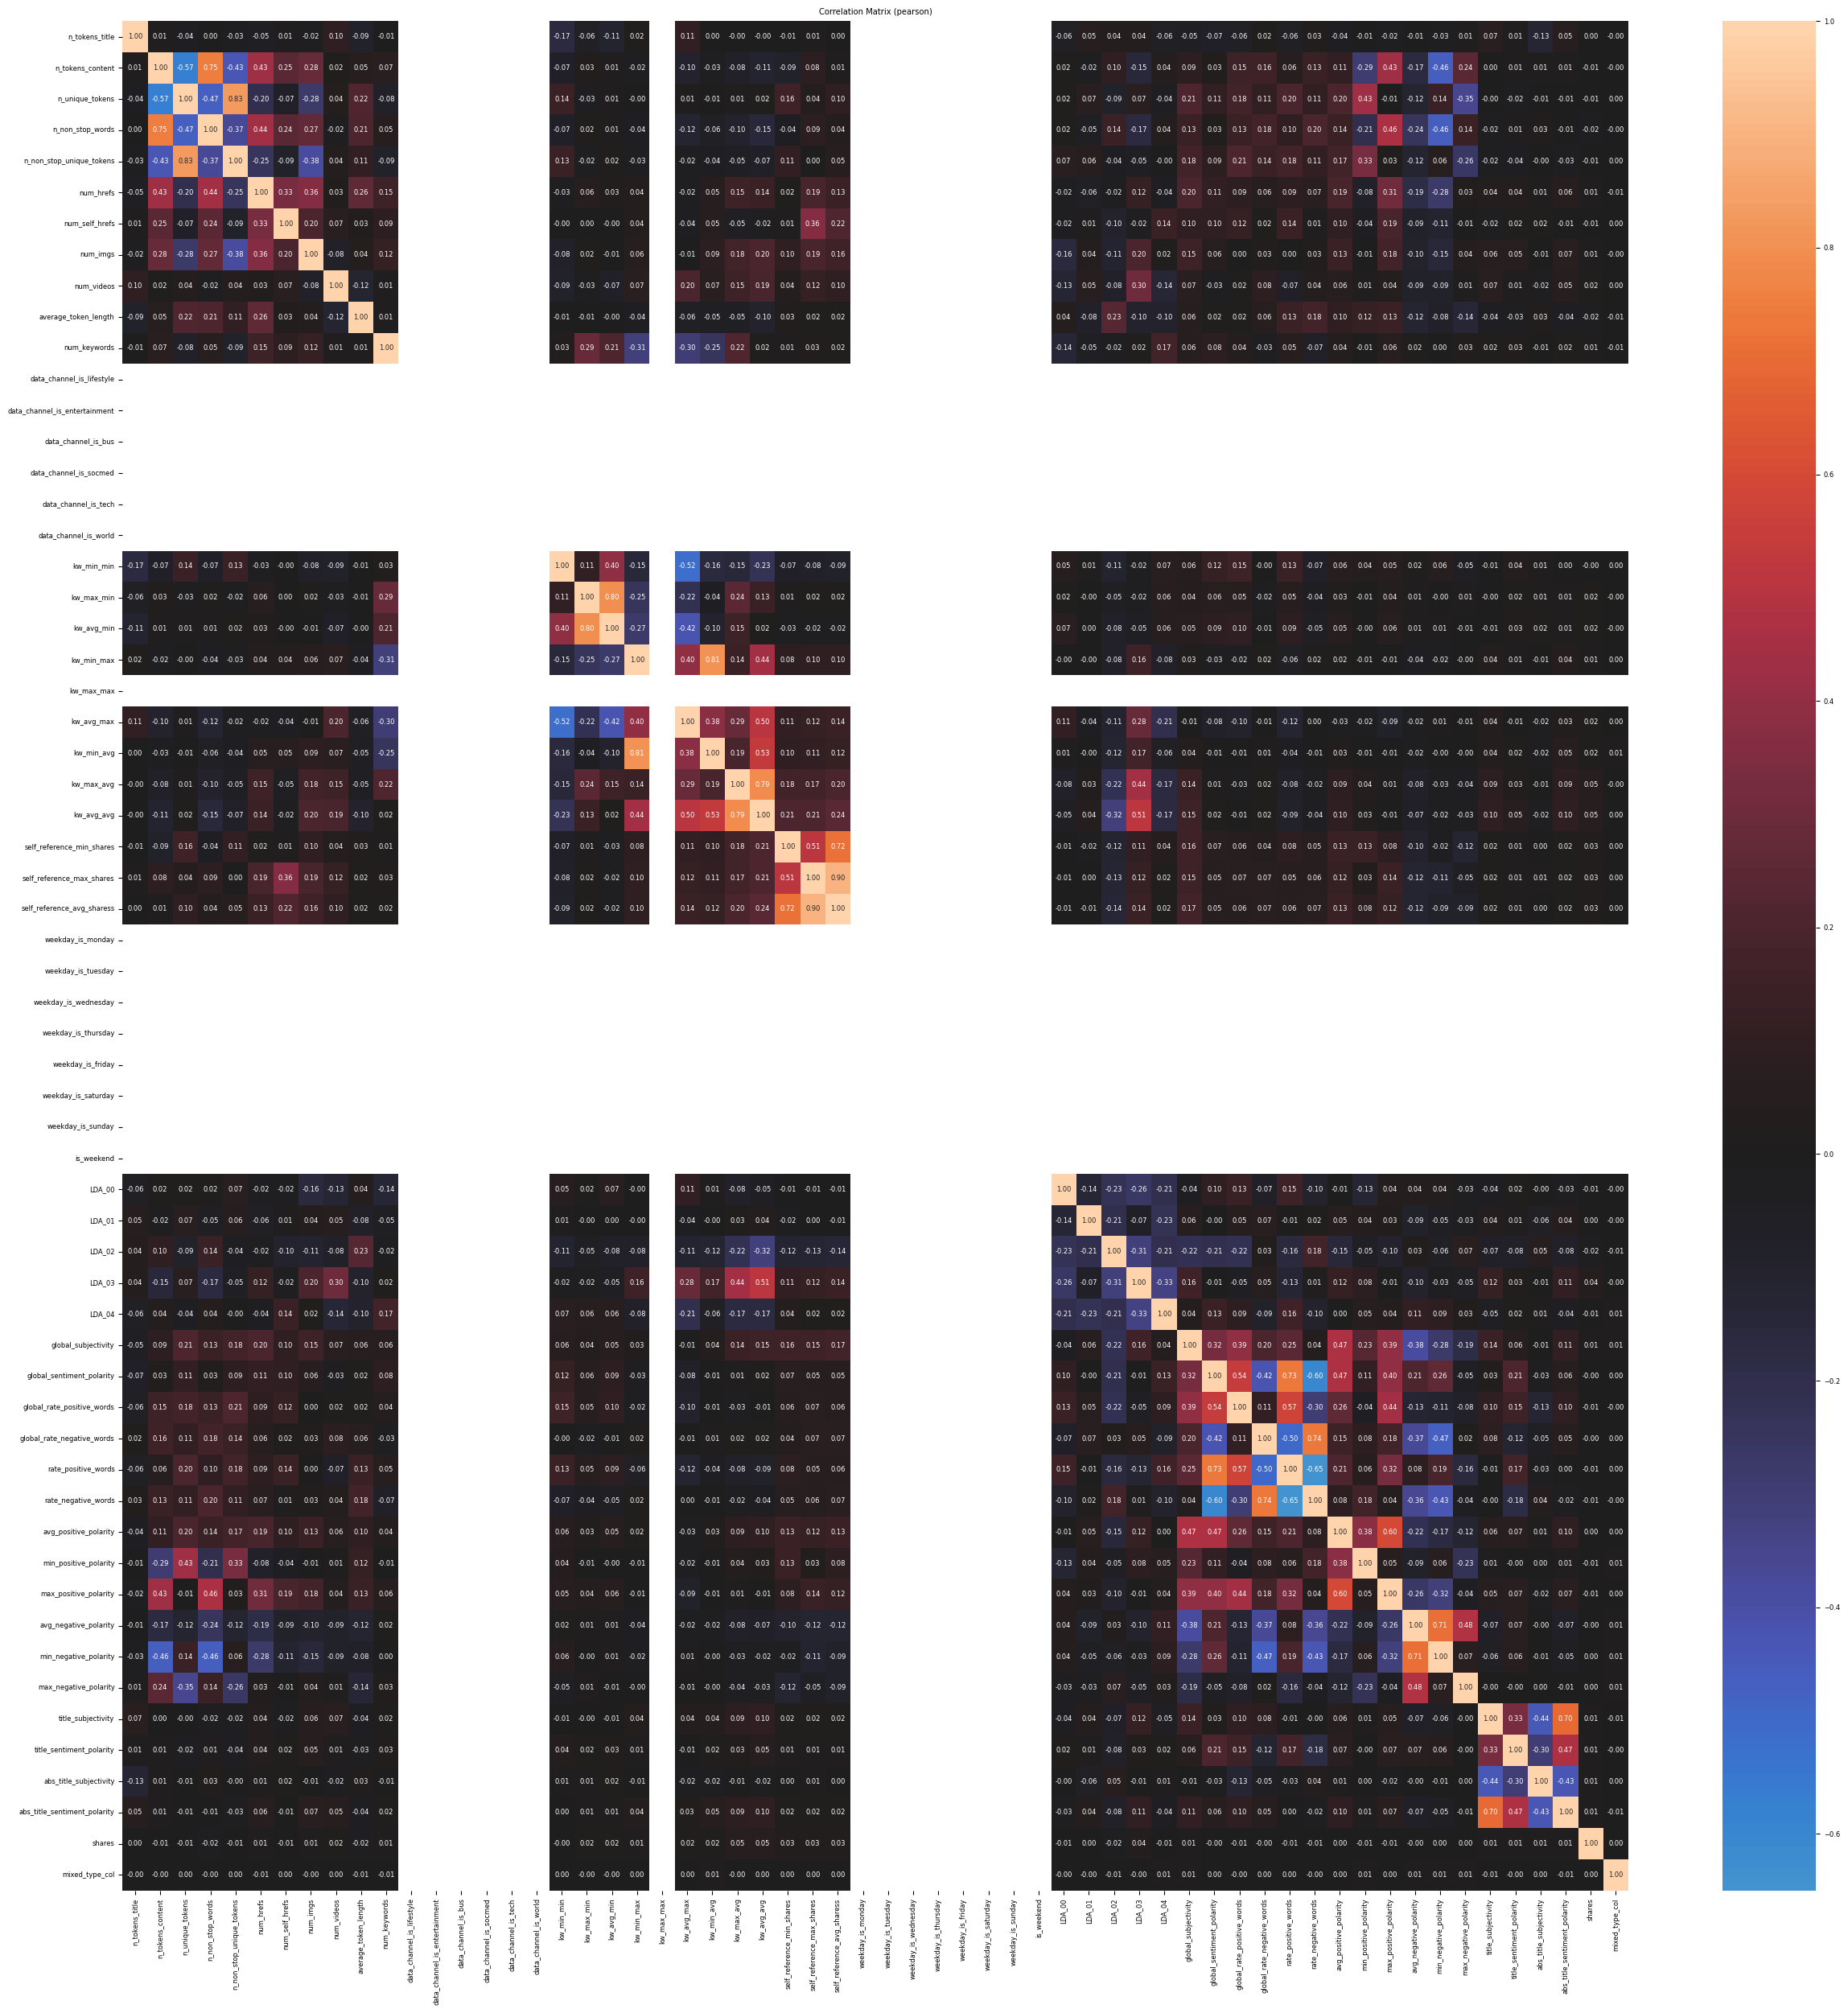

In [34]:
eda_clipped = EDAPlotter(df_clean, corr_method="pearson")
# Volver a graficar con los datos ya limpios
eda_clipped.plot_boxplots()
corr2 = eda_clipped.correlation(plot=True)

# **Preprocessing and Feature Engineering**

In [40]:
def prepare_train_test(df: pd.DataFrame, 
                       target_col: str = 'shares', 
                       test_size: float = 0.2, 
                       random_state: int = 42, 
                       stratify: bool = True, 
                       verbose: bool = True):
    "Prepares training and testing datasets for binary classification."
    df_clean = df.copy()

    # --- Step 1: Handle Missing Values in the Target ---
    if verbose:
        print(f"Filas antes de limpiar: {len(df_clean)}")
        print(f"Número de filas con '{target_col}' faltantes: {df_clean[target_col].isnull().sum()}")

    df_clean.dropna(subset=[target_col], inplace=True)

    if verbose:
        print(f"Filas después de limpiar: {len(df_clean)}")

    # --- Step 2: Create Binary Classification Target ---
    threshold = df_clean[target_col].median()
    df_clean['popular'] = (df_clean[target_col] > threshold).astype(int)

    if verbose:
        print(f"\nUsando umbral de popularidad = {threshold:.0f} ({target_col} mediana).")
        print("\nDistribución de clases binarias:")
        print(df_clean['popular'].value_counts(normalize=True).rename('proporción'))

    # --- Step 3: Define X and y ---
    X = df_clean.drop([target_col, 'popular'], axis=1)
    y = df_clean['popular']

    # --- Step 4: Train-Test Split ---
    stratify_y = y if stratify else None
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=stratify_y
    )

    if verbose:
        print(f"\nTamaño del conjunto de entrenamiento: {len(X_train)}")
        print(f"Tamaño del conjunto de prueba: {len(X_test)}")
        print("="*60)

    return X_train, X_test, y_train, y_test, threshold, df_clean

def baseline_classification(
    X_train, y_train, X_test, y_test,
    impute_strategy: str = "mean",
    baseline_strategy: str = "stratified",  # "most_frequent", "uniform", etc.
    random_state: int = 42,
    return_pipeline: bool = False
) -> Tuple[Dict[str, Any], Optional[Pipeline]]:
    """
    Entrena un baseline (DummyClassifier) en un pipeline con imputación
    y devuelve métricas + (opcional) el pipeline entrenado.
    """
    pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy=impute_strategy)),
        ("classifier", DummyClassifier(strategy=baseline_strategy, random_state=random_state))
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    metrics = {
        "accuracy": float(accuracy_score(y_test, y_pred)),
        "report": classification_report(y_test, y_pred, zero_division=0)
    }

    # Si hay predict_proba y el problema es binario, calculamos AUC
    try:
        proba = pipe.predict_proba(X_test)
        if proba is not None and proba.shape[1] == 2:
            metrics["roc_auc"] = float(roc_auc_score(y_test, proba[:, 1]))
    except Exception:
        pass

    if return_pipeline:
        return metrics, pipe
    return metrics, None

In [41]:
X_train, X_test, y_train, y_test, threshold, df_ready = prepare_train_test(df_numeric)
baseline_metrics, baseline_pipe = baseline_classification(
    X_train, y_train, X_test, y_test,
    impute_strategy="median",
    baseline_strategy="stratified",
    random_state=Config().random_state,
    return_pipeline=True
)

Filas antes de limpiar: 39805
Número de filas con 'shares' faltantes: 0
Filas después de limpiar: 39805

Usando umbral de popularidad = 1400 (shares mediana).

Distribución de clases binarias:
popular
0    0.502424
1    0.497576
Name: proporción, dtype: float64

Tamaño del conjunto de entrenamiento: 31844
Tamaño del conjunto de prueba: 7961


# **Modeling**

In [52]:
""""def setup_mlflow_experiment(
    experiment_name: str = "Online_News_Popularity_Estudio_Optuna",
    tracking_dir: str = "mlruns",
    metric_name: str = "auc",
    create_dir: bool = True
) -> Tuple[str, MLflowCallback]:
    # 1) Asegurar ruta absoluta
    tracking_abs = os.path.abspath(tracking_dir)
    if create_dir:
        os.makedirs(tracking_abs, exist_ok=True)

    # 2) Configurar MLflow
    mlflow.set_tracking_uri()     # en local basta la ruta; no hace falta "file://"
    mlflow.set_experiment(experiment_name)

    # 3) Construir callback para Optuna
    mlflow_cb = MLflowCallback(
        tracking_uri=mlflow.get_tracking_uri(),
        metric_name=metric_name
    )
    return tracking_abs, mlflow_cb """""
def setup_mlflow_experiment(
    experiment_name: str = "Online_News_Popularity_Estudio_Optuna",
    tracking_dir: str = "mlruns",
    metric_name: str = "auc",
):
    tracking_abs = Path(tracking_dir).resolve()

    # URI correcta en Windows/Mac/Linux
    tracking_uri = tracking_abs.as_uri()  # p.ej. 'file:///C:/Users/.../mlruns'

    mlflow.set_tracking_uri(tracking_uri)

    # Desactiva el Model Registry (no soportado en file store)
    mlflow.set_registry_uri("")  # esquema vacío = sin registry

    mlflow.set_experiment(experiment_name)

    mlflow_cb = MLflowCallback(
        tracking_uri=mlflow.get_tracking_uri(),
        metric_name=metric_name
    )
    return tracking_uri, mlflow_cb

In [53]:
tracking_uri, mlflow_callback = setup_mlflow_experiment(
    experiment_name="Online_News_Popularity_Estudio_Optuna",
    tracking_dir="mlruns",
    metric_name="auc"
)

2025/10/30 20:38:47 INFO mlflow.tracking.fluent: Experiment with name 'Online_News_Popularity_Estudio_Optuna' does not exist. Creating a new experiment.
C:\Users\betoa\AppData\Local\Temp\ipykernel_17180\133259683.py:39: ExperimentalWarning: MLflowCallback is experimental (supported from v1.4.0). The interface can change in the future.
  mlflow_cb = MLflowCallback(


In [58]:
def run_optuna_study(
    X_train, y_train,
    study_name: str = "optuna_study",
    n_trials: int = 50,
    cv: int = 3,
    metric_name: str = "roc_auc",                 # métrica objetivo de Optuna
    extra_metrics: Iterable[str] = ("accuracy",), # métricas adicionales
    enable_models: Iterable[str] = ("RandomForest", "MLP", "XGBoost", "LightGBM"),
    random_state: int = 42,
    mlflow_callback=None,                         # puede ser el callback de MLflow o None
    n_jobs_cv: int = -1
) -> Tuple[optuna.Study, Dict[str, Any]]:
    """
    Lanza una búsqueda con Optuna y devuelve (study, best_summary).
    Registra en MLflow si pasas un callback en 'mlflow_callback'.
    """

    # mapa seguro para MLP (evita eval)
    HIDDEN_MAP = {
        "50": (50,),
        "100": (100,),
        "50x50": (50, 50),
    }

    # filtra modelos disponibles (por si no están instalados)
    enabled = []
    for m in enable_models:
        if m == "XGBoost" and xgb is None:
            print("[warn] XGBoost no disponible. Se omite.")
            continue
        if m == "LightGBM" and lgb is None:
            print("[warn] LightGBM no disponible. Se omite.")
            continue
        enabled.append(m)
    if not enabled:
        raise ValueError("No hay modelos habilitados/instalados para probar.")

    scoring = [metric_name, *extra_metrics]

    def build_estimator(trial) -> Pipeline:
        """Crea el estimador (opcionalmente con scaler) según el modelo elegido."""
        name = trial.suggest_categorical("classifier", enabled)

        if name == "RandomForest":
            clf = RandomForestClassifier(
                n_estimators=trial.suggest_int("rf_n_estimators", 50, 400),
                max_depth=trial.suggest_int("rf_max_depth", 5, 30),
                random_state=random_state,
                n_jobs=-1,
            )
            steps = [("classifier", clf)]  # RF no necesita scaler
        elif name == "MLP":
            hidden_key = trial.suggest_categorical("mlp_hidden_layers", list(HIDDEN_MAP.keys()))
            clf = MLPClassifier(
                hidden_layer_sizes=HIDDEN_MAP[hidden_key],
                alpha=trial.suggest_float("mlp_alpha", 1e-5, 1e-1, log=True),
                max_iter=300,
                early_stopping=True,
                random_state=random_state,
            )
            steps = [("scaler", StandardScaler()), ("classifier", clf)]
        elif name == "XGBoost":
            clf = xgb.XGBClassifier(
                n_estimators=trial.suggest_int("xgb_n_estimators", 100, 800),
                learning_rate=trial.suggest_float("xgb_learning_rate", 0.01, 0.3),
                max_depth=trial.suggest_int("xgb_max_depth", 3, 10),
                subsample=trial.suggest_float("xgb_subsample", 0.6, 1.0),
                colsample_bytree=trial.suggest_float("xgb_colsample", 0.6, 1.0),
                objective="binary:logistic",
                eval_metric="logloss",
                tree_method="hist",
                random_state=random_state,
                n_jobs=-1,
            )
            steps = [("classifier", clf)]  # XGB no necesita scaler
        elif name == "LightGBM":
            clf = lgb.LGBMClassifier(
                n_estimators=trial.suggest_int("lgbm_n_estimators", 100, 800),
                learning_rate=trial.suggest_float("lgbm_learning_rate", 0.01, 0.3),
                num_leaves=trial.suggest_int("lgbm_num_leaves", 20, 200),
                subsample=trial.suggest_float("lgbm_subsample", 0.6, 1.0),
                colsample_bytree=trial.suggest_float("lgbm_colsample", 0.6, 1.0),
                objective="binary",
                random_state=random_state,
                n_jobs=-1,
            )
            steps = [("classifier", clf)]
        else:
            # fallback para que nunca falle
            clf = DummyClassifier(strategy="stratified", random_state=random_state)
            steps = [("classifier", clf)]

        return Pipeline(steps=steps)

    def objective(trial):
        # si usas MLflow callback no hace falta start_run aquí; el callback se encarga
        pipeline = build_estimator(trial)

        scores = cross_validate(
            pipeline, X_train, y_train,
            cv=cv, scoring=scoring, n_jobs=n_jobs_cv, error_score="raise"
        )

        mean_target = float(np.mean(scores[f"test_{metric_name}"]))
        # guarda métricas extra en user_attrs para imprimir luego
        for m in extra_metrics:
            trial.set_user_attr(m, float(np.mean(scores[f"test_{m}"])))
        return mean_target

    study = optuna.create_study(direction="maximize", study_name=study_name)
    callbacks = []
    if mlflow_callback is not None:
        callbacks.append(mlflow_callback)
    # callback para ver progreso por consola
    def print_metrics_callback(study, trial):
        extras = " ".join(
            f"{m}: {trial.user_attrs.get(m, float('nan')):.4f}" for m in extra_metrics
        )
        print(f"Trial {trial.number} → {metric_name.upper()}: {trial.value:.4f} | {extras}")

    callbacks.append(print_metrics_callback)

    study.optimize(objective, n_trials=n_trials, n_jobs=1, callbacks=callbacks)

    # resumen “bonito”
    best = study.best_trial
    summary = {
        "metric": metric_name,
        "best_value": float(best.value),
        "best_params": best.params,
        **{f"cv_{m}": float(best.user_attrs.get(m)) for m in extra_metrics},
        "n_trials": len(study.trials),
    }
    return study, summary

In [59]:
study, best = run_optuna_study(
    X_train, y_train,
    study_name="Online_News_Popularity_Estudio_Optuna",
    n_trials=50,
    cv=3,
    metric_name="roc_auc",
    extra_metrics=("accuracy",),
    enable_models=("RandomForest", "MLP", "XGBoost", "LightGBM"),
    random_state=42,
    mlflow_callback=mlflow_callback,   # o None si no usas MLflow
    n_jobs_cv=-1
)

print("\n=== RESULTADO ===")
print(f"Best {best['metric']}: {best['best_value']:.4f}")
print(f"CV Accuracy (trial mejor): {best.get('cv_accuracy'):.4f}")
print("Best params:")
for k,v in best["best_params"].items():
    print(f"  {k}: {v}")

[I 2025-10-30 20:46:27,745] A new study created in memory with name: Online_News_Popularity_Estudio_Optuna
[I 2025-10-30 20:46:50,721] Trial 0 finished with value: 0.7117593030136918 and parameters: {'classifier': 'XGBoost', 'xgb_n_estimators': 632, 'xgb_learning_rate': 0.017255749918063695, 'xgb_max_depth': 7, 'xgb_subsample': 0.7129816714552041, 'xgb_colsample': 0.8146542751948198}. Best is trial 0 with value: 0.7117593030136918.


Trial 0 → ROC_AUC: 0.7118 | accuracy: 0.6551


[I 2025-10-30 20:47:04,242] Trial 1 finished with value: 0.6999963117467015 and parameters: {'classifier': 'LightGBM', 'lgbm_n_estimators': 283, 'lgbm_learning_rate': 0.1315920095905494, 'lgbm_num_leaves': 198, 'lgbm_subsample': 0.9724347767945271, 'lgbm_colsample': 0.8913916995637317}. Best is trial 0 with value: 0.7117593030136918.


Trial 1 → ROC_AUC: 0.7000 | accuracy: 0.6428


[I 2025-10-30 20:47:12,745] Trial 2 finished with value: 0.7073261094522437 and parameters: {'classifier': 'XGBoost', 'xgb_n_estimators': 247, 'xgb_learning_rate': 0.050374509242816536, 'xgb_max_depth': 5, 'xgb_subsample': 0.7499702945192729, 'xgb_colsample': 0.9192554085357225}. Best is trial 0 with value: 0.7117593030136918.


Trial 2 → ROC_AUC: 0.7073 | accuracy: 0.6526


[I 2025-10-30 20:47:27,175] Trial 3 finished with value: 0.7080921117535733 and parameters: {'classifier': 'LightGBM', 'lgbm_n_estimators': 378, 'lgbm_learning_rate': 0.01933534937898393, 'lgbm_num_leaves': 134, 'lgbm_subsample': 0.6564905504944027, 'lgbm_colsample': 0.9140763386703723}. Best is trial 0 with value: 0.7117593030136918.


Trial 3 → ROC_AUC: 0.7081 | accuracy: 0.6521


[I 2025-10-30 20:47:44,775] Trial 4 finished with value: 0.7087753324719479 and parameters: {'classifier': 'LightGBM', 'lgbm_n_estimators': 491, 'lgbm_learning_rate': 0.03437411495627211, 'lgbm_num_leaves': 189, 'lgbm_subsample': 0.689363144357101, 'lgbm_colsample': 0.8120885914682593}. Best is trial 0 with value: 0.7117593030136918.


Trial 4 → ROC_AUC: 0.7088 | accuracy: 0.6501


[I 2025-10-30 20:47:49,175] Trial 5 finished with value: 0.6792525738839646 and parameters: {'classifier': 'MLP', 'mlp_hidden_layers': '50x50', 'mlp_alpha': 0.00022898011800516794}. Best is trial 0 with value: 0.7117593030136918.


Trial 5 → ROC_AUC: 0.6793 | accuracy: 0.6288


[I 2025-10-30 20:47:53,702] Trial 6 finished with value: 0.7010295397918326 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 88, 'rf_max_depth': 19}. Best is trial 0 with value: 0.7117593030136918.


Trial 6 → ROC_AUC: 0.7010 | accuracy: 0.6469


[I 2025-10-30 20:48:07,960] Trial 7 finished with value: 0.7092158139763783 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 313, 'rf_max_depth': 20}. Best is trial 0 with value: 0.7117593030136918.


Trial 7 → ROC_AUC: 0.7092 | accuracy: 0.6505


[I 2025-10-30 20:48:11,679] Trial 8 finished with value: 0.6993096559291149 and parameters: {'classifier': 'LightGBM', 'lgbm_n_estimators': 361, 'lgbm_learning_rate': 0.09369877348747295, 'lgbm_num_leaves': 51, 'lgbm_subsample': 0.6016033620344323, 'lgbm_colsample': 0.6692137487880021}. Best is trial 0 with value: 0.7117593030136918.


Trial 8 → ROC_AUC: 0.6993 | accuracy: 0.6462


[I 2025-10-30 20:48:31,487] Trial 9 finished with value: 0.7009472977983996 and parameters: {'classifier': 'LightGBM', 'lgbm_n_estimators': 727, 'lgbm_learning_rate': 0.2634299981181951, 'lgbm_num_leaves': 161, 'lgbm_subsample': 0.704853459912678, 'lgbm_colsample': 0.6126086197478348}. Best is trial 0 with value: 0.7117593030136918.


Trial 9 → ROC_AUC: 0.7009 | accuracy: 0.6434


[I 2025-10-30 20:48:51,042] Trial 10 finished with value: 0.6801559656483128 and parameters: {'classifier': 'XGBoost', 'xgb_n_estimators': 797, 'xgb_learning_rate': 0.29220304792506946, 'xgb_max_depth': 9, 'xgb_subsample': 0.629775420532186, 'xgb_colsample': 0.6396263839833474}. Best is trial 0 with value: 0.7117593030136918.


Trial 10 → ROC_AUC: 0.6802 | accuracy: 0.6307


[I 2025-10-30 20:49:08,222] Trial 11 finished with value: 0.7090938672350672 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 392, 'rf_max_depth': 27}. Best is trial 0 with value: 0.7117593030136918.


Trial 11 → ROC_AUC: 0.7091 | accuracy: 0.6520


[I 2025-10-30 20:49:15,471] Trial 12 finished with value: 0.6914783751027652 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 327, 'rf_max_depth': 7}. Best is trial 0 with value: 0.7117593030136918.


Trial 12 → ROC_AUC: 0.6915 | accuracy: 0.6391


[I 2025-10-30 20:49:38,087] Trial 13 finished with value: 0.710681331417438 and parameters: {'classifier': 'XGBoost', 'xgb_n_estimators': 636, 'xgb_learning_rate': 0.01721150682827094, 'xgb_max_depth': 8, 'xgb_subsample': 0.9962397349083603, 'xgb_colsample': 0.7863473230477892}. Best is trial 0 with value: 0.7117593030136918.


Trial 13 → ROC_AUC: 0.7107 | accuracy: 0.6538


[I 2025-10-30 20:49:58,968] Trial 14 finished with value: 0.7109486538707088 and parameters: {'classifier': 'XGBoost', 'xgb_n_estimators': 633, 'xgb_learning_rate': 0.019987413486469346, 'xgb_max_depth': 8, 'xgb_subsample': 0.9893693002260475, 'xgb_colsample': 0.7848209880891137}. Best is trial 0 with value: 0.7117593030136918.


Trial 14 → ROC_AUC: 0.7109 | accuracy: 0.6545


[I 2025-10-30 20:50:12,363] Trial 15 finished with value: 0.7002704069203514 and parameters: {'classifier': 'XGBoost', 'xgb_n_estimators': 546, 'xgb_learning_rate': 0.09611092306966419, 'xgb_max_depth': 7, 'xgb_subsample': 0.9925058125022107, 'xgb_colsample': 0.7958445108446265}. Best is trial 0 with value: 0.7117593030136918.


Trial 15 → ROC_AUC: 0.7003 | accuracy: 0.6484


[I 2025-10-30 20:50:17,808] Trial 16 finished with value: 0.6967753562946525 and parameters: {'classifier': 'XGBoost', 'xgb_n_estimators': 664, 'xgb_learning_rate': 0.16022399672899723, 'xgb_max_depth': 3, 'xgb_subsample': 0.7920053967063818, 'xgb_colsample': 0.8431182284278991}. Best is trial 0 with value: 0.7117593030136918.


Trial 16 → ROC_AUC: 0.6968 | accuracy: 0.6425


[I 2025-10-30 20:50:21,073] Trial 17 finished with value: 0.6884631346795667 and parameters: {'classifier': 'MLP', 'mlp_hidden_layers': '50', 'mlp_alpha': 0.09170551117591047}. Best is trial 0 with value: 0.7117593030136918.


Trial 17 → ROC_AUC: 0.6885 | accuracy: 0.6368


[I 2025-10-30 20:51:32,781] Trial 18 finished with value: 0.6960155796916253 and parameters: {'classifier': 'XGBoost', 'xgb_n_estimators': 393, 'xgb_learning_rate': 0.12221370476553248, 'xgb_max_depth': 10, 'xgb_subsample': 0.6761005217961059, 'xgb_colsample': 0.708433543016456}. Best is trial 0 with value: 0.7117593030136918.


Trial 18 → ROC_AUC: 0.6960 | accuracy: 0.6425


[I 2025-10-30 20:51:41,757] Trial 19 finished with value: 0.7102504081975208 and parameters: {'classifier': 'XGBoost', 'xgb_n_estimators': 464, 'xgb_learning_rate': 0.017005193892747794, 'xgb_max_depth': 6, 'xgb_subsample': 0.8709872020716979, 'xgb_colsample': 0.8967286708623282}. Best is trial 0 with value: 0.7117593030136918.


Trial 19 → ROC_AUC: 0.7103 | accuracy: 0.6551


[I 2025-10-30 20:52:00,566] Trial 20 finished with value: 0.6940738183171772 and parameters: {'classifier': 'XGBoost', 'xgb_n_estimators': 784, 'xgb_learning_rate': 0.19320061953454304, 'xgb_max_depth': 8, 'xgb_subsample': 0.8855774726160297, 'xgb_colsample': 0.7320482157433619}. Best is trial 0 with value: 0.7117593030136918.


Trial 20 → ROC_AUC: 0.6941 | accuracy: 0.6403


[I 2025-10-30 20:52:21,706] Trial 21 finished with value: 0.7110703450000596 and parameters: {'classifier': 'XGBoost', 'xgb_n_estimators': 621, 'xgb_learning_rate': 0.01699566407139117, 'xgb_max_depth': 8, 'xgb_subsample': 0.9858055621070595, 'xgb_colsample': 0.7869104733661746}. Best is trial 0 with value: 0.7117593030136918.


Trial 21 → ROC_AUC: 0.7111 | accuracy: 0.6545


[I 2025-10-30 20:52:36,359] Trial 22 finished with value: 0.7021864795028495 and parameters: {'classifier': 'XGBoost', 'xgb_n_estimators': 634, 'xgb_learning_rate': 0.06565404729018257, 'xgb_max_depth': 7, 'xgb_subsample': 0.9201701854586464, 'xgb_colsample': 0.8214713344879341}. Best is trial 0 with value: 0.7117593030136918.


Trial 22 → ROC_AUC: 0.7022 | accuracy: 0.6473


[I 2025-10-30 20:52:56,884] Trial 23 finished with value: 0.712072987727273 and parameters: {'classifier': 'XGBoost', 'xgb_n_estimators': 527, 'xgb_learning_rate': 0.01577930906814356, 'xgb_max_depth': 8, 'xgb_subsample': 0.7079067091845572, 'xgb_colsample': 0.9873895573009784}. Best is trial 23 with value: 0.712072987727273.


Trial 23 → ROC_AUC: 0.7121 | accuracy: 0.6559


[I 2025-10-30 20:53:00,375] Trial 24 finished with value: 0.6872422368415386 and parameters: {'classifier': 'MLP', 'mlp_hidden_layers': '100', 'mlp_alpha': 1.1385407361514477e-05}. Best is trial 23 with value: 0.712072987727273.


Trial 24 → ROC_AUC: 0.6872 | accuracy: 0.6340


[I 2025-10-30 20:53:09,500] Trial 25 finished with value: 0.6999867116431489 and parameters: {'classifier': 'XGBoost', 'xgb_n_estimators': 503, 'xgb_learning_rate': 0.07085247124107338, 'xgb_max_depth': 6, 'xgb_subsample': 0.7206722084383581, 'xgb_colsample': 0.9962827653015901}. Best is trial 23 with value: 0.712072987727273.


Trial 25 → ROC_AUC: 0.7000 | accuracy: 0.6484


[I 2025-10-30 20:53:40,801] Trial 26 finished with value: 0.7114861735611622 and parameters: {'classifier': 'XGBoost', 'xgb_n_estimators': 363, 'xgb_learning_rate': 0.01236816272343344, 'xgb_max_depth': 10, 'xgb_subsample': 0.7025204811777226, 'xgb_colsample': 0.9849347283582621}. Best is trial 23 with value: 0.712072987727273.


Trial 26 → ROC_AUC: 0.7115 | accuracy: 0.6544


[I 2025-10-30 20:54:03,504] Trial 27 finished with value: 0.7017253456457272 and parameters: {'classifier': 'XGBoost', 'xgb_n_estimators': 343, 'xgb_learning_rate': 0.060102106747147416, 'xgb_max_depth': 10, 'xgb_subsample': 0.6911566939337938, 'xgb_colsample': 0.9971037742415487}. Best is trial 23 with value: 0.712072987727273.


Trial 27 → ROC_AUC: 0.7017 | accuracy: 0.6470


[I 2025-10-30 20:54:11,877] Trial 28 finished with value: 0.6730931583869725 and parameters: {'classifier': 'XGBoost', 'xgb_n_estimators': 183, 'xgb_learning_rate': 0.24144835938393303, 'xgb_max_depth': 9, 'xgb_subsample': 0.6077682388660286, 'xgb_colsample': 0.9242070077386422}. Best is trial 23 with value: 0.712072987727273.


Trial 28 → ROC_AUC: 0.6731 | accuracy: 0.6238


[I 2025-10-30 20:54:14,476] Trial 29 finished with value: 0.6817823032383302 and parameters: {'classifier': 'MLP', 'mlp_hidden_layers': '50x50', 'mlp_alpha': 0.04887812142617257}. Best is trial 23 with value: 0.712072987727273.


Trial 29 → ROC_AUC: 0.6818 | accuracy: 0.6315


[I 2025-10-30 20:54:19,455] Trial 30 finished with value: 0.6969788444949435 and parameters: {'classifier': 'XGBoost', 'xgb_n_estimators': 350, 'xgb_learning_rate': 0.11494112820430374, 'xgb_max_depth': 5, 'xgb_subsample': 0.7686650318180486, 'xgb_colsample': 0.9602675695298613}. Best is trial 23 with value: 0.712072987727273.


Trial 30 → ROC_AUC: 0.6970 | accuracy: 0.6439


[I 2025-10-30 20:54:48,838] Trial 31 finished with value: 0.7122754558381077 and parameters: {'classifier': 'XGBoost', 'xgb_n_estimators': 553, 'xgb_learning_rate': 0.015404961436226843, 'xgb_max_depth': 9, 'xgb_subsample': 0.6674950536830967, 'xgb_colsample': 0.8617345640278149}. Best is trial 31 with value: 0.7122754558381077.


Trial 31 → ROC_AUC: 0.7123 | accuracy: 0.6551


[I 2025-10-30 20:58:38,730] Trial 32 finished with value: 0.7054971819545316 and parameters: {'classifier': 'XGBoost', 'xgb_n_estimators': 540, 'xgb_learning_rate': 0.04465046455123536, 'xgb_max_depth': 9, 'xgb_subsample': 0.6621865383563236, 'xgb_colsample': 0.8726173273538933}. Best is trial 31 with value: 0.7122754558381077.


Trial 32 → ROC_AUC: 0.7055 | accuracy: 0.6506


[I 2025-10-30 20:59:15,404] Trial 33 finished with value: 0.7123327284949013 and parameters: {'classifier': 'XGBoost', 'xgb_n_estimators': 430, 'xgb_learning_rate': 0.010837091310620764, 'xgb_max_depth': 10, 'xgb_subsample': 0.7167908429106665, 'xgb_colsample': 0.9547003688579615}. Best is trial 33 with value: 0.7123327284949013.


Trial 33 → ROC_AUC: 0.7123 | accuracy: 0.6557


[I 2025-10-30 20:59:43,005] Trial 34 finished with value: 0.7082622483657546 and parameters: {'classifier': 'XGBoost', 'xgb_n_estimators': 575, 'xgb_learning_rate': 0.03842422114177154, 'xgb_max_depth': 9, 'xgb_subsample': 0.7389579172674635, 'xgb_colsample': 0.950752219753584}. Best is trial 33 with value: 0.7123327284949013.


Trial 34 → ROC_AUC: 0.7083 | accuracy: 0.6534


[I 2025-10-30 20:59:46,561] Trial 35 finished with value: 0.6846442687771305 and parameters: {'classifier': 'LightGBM', 'lgbm_n_estimators': 150, 'lgbm_learning_rate': 0.2620714188539246, 'lgbm_num_leaves': 20, 'lgbm_subsample': 0.9113772588229915, 'lgbm_colsample': 0.7349818786099956}. Best is trial 33 with value: 0.7123327284949013.


Trial 35 → ROC_AUC: 0.6846 | accuracy: 0.6372


[I 2025-10-30 20:59:57,160] Trial 36 finished with value: 0.6976891296461898 and parameters: {'classifier': 'XGBoost', 'xgb_n_estimators': 445, 'xgb_learning_rate': 0.08738813179794298, 'xgb_max_depth': 7, 'xgb_subsample': 0.6492510711321349, 'xgb_colsample': 0.862458504923244}. Best is trial 33 with value: 0.7123327284949013.


Trial 36 → ROC_AUC: 0.6977 | accuracy: 0.6442


[I 2025-10-30 21:00:19,299] Trial 37 finished with value: 0.7056019314387787 and parameters: {'classifier': 'XGBoost', 'xgb_n_estimators': 447, 'xgb_learning_rate': 0.04058780849893612, 'xgb_max_depth': 9, 'xgb_subsample': 0.7033549130571957, 'xgb_colsample': 0.9432506531897518}. Best is trial 33 with value: 0.7123327284949013.


Trial 37 → ROC_AUC: 0.7056 | accuracy: 0.6486


[I 2025-10-30 21:00:21,079] Trial 38 finished with value: 0.6808980713207737 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 65, 'rf_max_depth': 5}. Best is trial 33 with value: 0.7123327284949013.


Trial 38 → ROC_AUC: 0.6809 | accuracy: 0.6315


[I 2025-10-30 21:00:38,095] Trial 39 finished with value: 0.6946706596371444 and parameters: {'classifier': 'LightGBM', 'lgbm_n_estimators': 665, 'lgbm_learning_rate': 0.19743799090667882, 'lgbm_num_leaves': 91, 'lgbm_subsample': 0.8313921214542673, 'lgbm_colsample': 0.9992165678619281}. Best is trial 33 with value: 0.7123327284949013.


Trial 39 → ROC_AUC: 0.6947 | accuracy: 0.6393


[I 2025-10-30 21:00:40,913] Trial 40 finished with value: 0.6873143492028454 and parameters: {'classifier': 'MLP', 'mlp_hidden_layers': '50', 'mlp_alpha': 0.0011242701616326516}. Best is trial 33 with value: 0.7123327284949013.


Trial 40 → ROC_AUC: 0.6873 | accuracy: 0.6369


[I 2025-10-30 21:01:33,704] Trial 41 finished with value: 0.711988999531817 and parameters: {'classifier': 'XGBoost', 'xgb_n_estimators': 719, 'xgb_learning_rate': 0.014183833742895998, 'xgb_max_depth': 10, 'xgb_subsample': 0.7140844617514365, 'xgb_colsample': 0.9707070155808967}. Best is trial 33 with value: 0.7123327284949013.


Trial 41 → ROC_AUC: 0.7120 | accuracy: 0.6557


[I 2025-10-30 21:02:16,992] Trial 42 finished with value: 0.7083497342029998 and parameters: {'classifier': 'XGBoost', 'xgb_n_estimators': 721, 'xgb_learning_rate': 0.037947135983443375, 'xgb_max_depth': 10, 'xgb_subsample': 0.7291698580458308, 'xgb_colsample': 0.8979701842221954}. Best is trial 33 with value: 0.7123327284949013.


Trial 42 → ROC_AUC: 0.7083 | accuracy: 0.6486


[I 2025-10-30 21:03:11,874] Trial 43 finished with value: 0.7137068702087662 and parameters: {'classifier': 'XGBoost', 'xgb_n_estimators': 690, 'xgb_learning_rate': 0.013192591041714705, 'xgb_max_depth': 10, 'xgb_subsample': 0.7690451890852374, 'xgb_colsample': 0.9689141728475538}. Best is trial 43 with value: 0.7137068702087662.


Trial 43 → ROC_AUC: 0.7137 | accuracy: 0.6559


[I 2025-10-30 21:04:06,154] Trial 44 finished with value: 0.7136608941353985 and parameters: {'classifier': 'XGBoost', 'xgb_n_estimators': 693, 'xgb_learning_rate': 0.010365637604268934, 'xgb_max_depth': 10, 'xgb_subsample': 0.8049554546142916, 'xgb_colsample': 0.9652206680590653}. Best is trial 43 with value: 0.7137068702087662.


Trial 44 → ROC_AUC: 0.7137 | accuracy: 0.6563


[I 2025-10-30 21:04:48,171] Trial 45 finished with value: 0.7093246324589909 and parameters: {'classifier': 'XGBoost', 'xgb_n_estimators': 697, 'xgb_learning_rate': 0.03994875576292415, 'xgb_max_depth': 10, 'xgb_subsample': 0.8429378459639542, 'xgb_colsample': 0.945134866352969}. Best is trial 43 with value: 0.7137068702087662.


Trial 45 → ROC_AUC: 0.7093 | accuracy: 0.6513


[I 2025-10-30 21:04:57,083] Trial 46 finished with value: 0.7063733891293738 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 191, 'rf_max_depth': 29}. Best is trial 43 with value: 0.7137068702087662.


Trial 46 → ROC_AUC: 0.7064 | accuracy: 0.6487


[I 2025-10-30 21:05:21,620] Trial 47 finished with value: 0.7028897462236122 and parameters: {'classifier': 'XGBoost', 'xgb_n_estimators': 573, 'xgb_learning_rate': 0.07857270989027126, 'xgb_max_depth': 9, 'xgb_subsample': 0.8151965798606847, 'xgb_colsample': 0.9219889759882113}. Best is trial 43 with value: 0.7137068702087662.


Trial 47 → ROC_AUC: 0.7029 | accuracy: 0.6468


[I 2025-10-30 21:05:32,782] Trial 48 finished with value: 0.6943971517316068 and parameters: {'classifier': 'LightGBM', 'lgbm_n_estimators': 567, 'lgbm_learning_rate': 0.18869936551779637, 'lgbm_num_leaves': 97, 'lgbm_subsample': 0.7959175319049083, 'lgbm_colsample': 0.7760640724521206}. Best is trial 43 with value: 0.7137068702087662.


Trial 48 → ROC_AUC: 0.6944 | accuracy: 0.6400


[I 2025-10-30 21:06:19,463] Trial 49 finished with value: 0.708727814023761 and parameters: {'classifier': 'XGBoost', 'xgb_n_estimators': 753, 'xgb_learning_rate': 0.03525804481300711, 'xgb_max_depth': 10, 'xgb_subsample': 0.7747811475223398, 'xgb_colsample': 0.9739670761319393}. Best is trial 43 with value: 0.7137068702087662.


Trial 49 → ROC_AUC: 0.7087 | accuracy: 0.6518

=== RESULTADO ===
Best roc_auc: 0.7137
CV Accuracy (trial mejor): 0.6559
Best params:
  classifier: XGBoost
  xgb_n_estimators: 690
  xgb_learning_rate: 0.013192591041714705
  xgb_max_depth: 10
  xgb_subsample: 0.7690451890852374
  xgb_colsample: 0.9689141728475538


In [60]:
def retrain_and_evaluate_best(
    study,
    X_train, y_train, X_test, y_test,
    feature_names: Optional[list] = None,
    experiment_name: str = "Online_News_Popularity_Estudio_Optuna",
    tracking_uri: Optional[str] = None,   # ej: 'file:///C:/.../mlruns'
    parent_from_best_trial: bool = True,
    random_state: int = 42,
) -> Tuple[Pipeline, Dict[str, Any], Optional[pd.DataFrame]]:
    # ---------- reconstruir el mejor estimador ----------
    best_params = study.best_params.copy()
    clf_name = best_params.pop("classifier")

    def _parse_mlp_hidden(val):
        # segura: acepta tuplas, '50', '(50,)', '50,50', etc.
        if isinstance(val, tuple): 
            return val
        if isinstance(val, str):
            s = val.strip().strip("()")
            if not s:
                return (50,)
            try:
                return tuple(int(x) for x in s.split(",") if x.strip())
            except Exception:
                return (50,)
        return (50,)

    model_params = {}
    steps = []

    if clf_name == "RandomForest":
        model_params = {k.replace("rf_", ""): v for k, v in best_params.items()}
        final_clf = RandomForestClassifier(random_state=random_state, n_jobs=-1, **model_params)
        # RF no requiere scaler
    elif clf_name == "MLP":
        if "mlp_hidden_layers" in best_params:
            best_params["hidden_layer_sizes"] = _parse_mlp_hidden(best_params.pop("mlp_hidden_layers"))
        model_params = {k.replace("mlp_", ""): v for k, v in best_params.items()}
        final_clf = MLPClassifier(max_iter=300, early_stopping=True, random_state=random_state, **model_params)
        steps.append(("scaler", StandardScaler()))  # MLP sí requiere escalado
    elif clf_name == "XGBoost":
        if xgb is None:
            raise RuntimeError("XGBoost no está instalado, no puedo reconstruir el mejor modelo.")
        model_params = {k.replace("xgb_", ""): v for k, v in best_params.items()}
        final_clf = xgb.XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",
            random_state=random_state,
            n_jobs=-1,
            **model_params
        )
        # XGBoost no requiere scaler
    elif clf_name == "LightGBM":
        if lgb is None:
            raise RuntimeError("LightGBM no está instalado, no puedo reconstruir el mejor modelo.")
        model_params = {k.replace("lgbm_", ""): v for k, v in best_params.items()}
        final_clf = lgb.LGBMClassifier(objective="binary", random_state=random_state, n_jobs=-1, **model_params)
        # LightGBM tampoco requiere scaler
    else:
        raise ValueError(f"Clasificador desconocido en best_params: {clf_name}")

    steps.append(("classifier", final_clf))
    final_pipeline = Pipeline(steps=steps)

    # ---------- MLflow ----------
    if tracking_uri:
        mlflow.set_tracking_uri(tracking_uri)
        # si usas file store local, desactiva registry:
        if tracking_uri.startswith("file:") or tracking_uri.startswith("file:///"):
            mlflow.set_registry_uri("")

    mlflow.set_experiment(experiment_name)

    parent_run_id = None
    if parent_from_best_trial:
        parent_run_id = study.best_trial.system_attrs.get("mlflow_run_id")

    metrics: Dict[str, Any] = {}
    importance_df: Optional[pd.DataFrame] = None

    with mlflow.start_run(
        run_name=f"Final_{clf_name}_Model",
        nested=True if parent_run_id else False,
        tags={"stage": "final_evaluation"},
        parent_run_id=parent_run_id
    ):
        # parámetros
        mlflow.log_param("classifier", clf_name)
        mlflow.log_params(model_params)

        # entrenar y evaluar
        final_pipeline.fit(X_train, y_train)
        y_pred = final_pipeline.predict(X_test)

        # si el modelo soporta proba, calcula AUC
        if hasattr(final_pipeline, "predict_proba"):
            y_proba = final_pipeline.predict_proba(X_test)[:, 1]
            metrics["final_auc"] = float(roc_auc_score(y_test, y_proba))
        else:
            metrics["final_auc"] = np.nan

        metrics["final_accuracy"] = float(accuracy_score(y_test, y_pred))
        metrics["classification_report"] = classification_report(
            y_test, y_pred, target_names=["Unpopular", "Popular"], zero_division=0
        )

        print(f"\nFinal Test AUC: {metrics['final_auc']:.4f}")
        print(f"Final Test Accuracy: {metrics['final_accuracy']:.4f}")
        print("\n--- Classification Report ---")
        print(metrics["classification_report"])

        # log métricas numéricas
        mlflow.log_metric("final_auc", metrics["final_auc"])
        mlflow.log_metric("final_accuracy", metrics["final_accuracy"])

        # matriz de confusión
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(
            cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Unpopular", "Popular"],
            yticklabels=["Unpopular", "Popular"]
        )
        plt.title("Confusion Matrix on Test Set")
        plt.xlabel("Predicted"); plt.ylabel("True")
        with tempfile.TemporaryDirectory() as tmpdir:
            cm_path = os.path.join(tmpdir, "confusion_matrix.png")
            plt.savefig(cm_path, bbox_inches="tight")
            mlflow.log_artifact(cm_path)
        plt.close()

        # importancias (si existen)
        clf = final_pipeline.named_steps["classifier"]
        if hasattr(clf, "feature_importances_") and feature_names is not None:
            importances = clf.feature_importances_
            importance_df = pd.DataFrame(
                {"Feature": feature_names, "Importance": importances}
            ).sort_values("Importance", ascending=False)

            plt.figure(figsize=(12, 8))
            sns.barplot(x="Importance", y="Feature", data=importance_df.head(20))
            plt.title(f"Top 20 Feature Importances — {clf.__class__.__name__}")
            with tempfile.TemporaryDirectory() as tmpdir:
                imp_path = os.path.join(tmpdir, "feature_importance.png")
                plt.savefig(imp_path, bbox_inches="tight")
                mlflow.log_artifact(imp_path)
            plt.close()

        # guarda el pipeline completo
        mlflow.sklearn.log_model(final_pipeline, artifact_path="final_model")

    print("\n✅ Modelo final registrado.")
    return final_pipeline, metrics, importance_df

In [63]:
final_model, final_metrics, feat_imp = retrain_and_evaluate_best(
    study,
    X_train, y_train, X_test, y_test,
    feature_names=list(X_train.columns),
    experiment_name="Online_News_Popularity_Estudio_Optuna",
    tracking_uri=tracking_uri,              # o None si ya está seteado
    parent_from_best_trial=True,
    random_state=42,
)

c:\Users\betoa\anaconda3\envs\mlops312\Lib\site-packages\xgboost\training.py:199: UserWarning: [21:13:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "colsample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Final Test AUC: 0.7258
Final Test Accuracy: 0.6632

--- Classification Report ---
              precision    recall  f1-score   support

   Unpopular       0.67      0.65      0.66      4000
     Popular       0.66      0.67      0.67      3961

    accuracy                           0.66      7961
   macro avg       0.66      0.66      0.66      7961
weighted avg       0.66      0.66      0.66      7961



2025/10/30 21:14:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/30 21:14:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



✅ Modelo final registrado.


Configuramos mlflow para que trabaje junto con optuna

In [ ]:
#Correr esto en bash para ver los experimentos en la UI de mlflow
#mlflow ui --backend-store-uri file:\notebooks\mlruns
